<h1> Project 1 </h1>

<b> Group: </b> A <br>
<b> Members: </b>
- Francisco Parente (frvi@itu.dk) <br>
- Janusz Wilczek (jawi@itu.dk) <br>
- Julia Justyna Maziarz (jmaz@itu.dk) <br>
- Juraj Septak (juse@itu.dk) <br>
- Lukas Sarka (lsar@itu.dk) <br>

<b> Country: </b> Sweden

<h2> Task 0: Data filtering and cleaning </h2>

<b> Task description: </b> 

Out of the raw dataset, create a processed data set that contains only fields and records that are relevant to your analysis. You are going to use this processed data set for all the tasks below.

Briefly describe your data set in a numerical summary (e.g. number/meaning of fields and records, statistical key metrics). 

In [1]:
import pandas as pd

import folium, json

import statsmodels.api as smapi
from scipy.stats import pearsonr, spearmanr, linregress
import numpy as np
from   statsmodels.stats.multitest  import multipletests

from sklearn import linear_model
from statsmodels.regression.linear_model import OLS
import statsmodels as sm

from datetime import timedelta

import matplotlib.pyplot as plt

<h3> Initial analysis and preparation of data </h3>

<b> WEATHER DATA </b>

In [2]:
'''Initial analysis of weather data'''
weather_data = pd.read_csv("../data/raw/weather/weather.csv", encoding = 'utf-8')
print('Shape: ',weather_data.shape) #checking the shape of the dataset
print('Empty cells: ',weather_data.isna().any().any()) #checking if the file has empty cells

'''Filtering the data valid for our country'''
SE_weather = weather_data[weather_data['iso3166-2'].str.startswith('SE')]

'''Creating smaller datasets'''
SE_weather_by_region = SE_weather.groupby(by = 'iso3166-2').agg(['min','mean','median','max'])
SE_weather_by_date = SE_weather.groupby(by = 'date').agg(['mean'])

Shape:  (20220, 9)
Empty cells:  False


<b> COUNTRY DATA </b>

In [3]:
'''Importing the country metadata from a JSON file'''
with open('../data/raw/metadata/se_metadata.json', 'r', encoding = 'utf-8') as file:
    country_metadata = json.load(file)

'''Importing the shape of country for creating a map'''
with open('../data/raw/shapefiles/se.geojson', 'r', encoding = 'utf-8') as file:
    country_shape = json.load(file)

<b> COVID-19 DATA </b> (additions)

In [4]:
'''Importing the data about hospitalizations due to COVID-19'''
SE_corona = pd.read_csv('../data/raw/corona/se_corona.csv', sep = '\t', encoding = 'utf-8')
print('Corona additions dataset shape: ', SE_corona.shape)
print('Empty cells: ',SE_corona.isna().any().any()) #checking if the file has empty cells

SE_corona

Corona additions dataset shape:  (8001, 3)
Empty cells:  False


,date,region_code,confirmed_addition
0,2021-02-18,Blekinge,23
1,2021-02-17,Blekinge,30
2,2021-02-16,Blekinge,50
3,2021-02-15,Blekinge,3
4,2021-02-14,Blekinge,3
...,...,...,...
7996,2020-02-08,Östergötland,0
7997,2020-02-07,Östergötland,0
7998,2020-02-06,Östergötland,0
7999,2020-02-05,Östergötland,0


In [5]:
'''Creating dataset of additions per region for use for maps'''

'''Creating a dictionary of ISO codes of Swedish regions'''
isocodes_dictionary = {country_metadata['country_metadata'][i]['covid_region_code'] : country_metadata['country_metadata'][i]['iso3166-2_code'] for i in range(len(country_metadata['country_metadata']))}
SE_corona['iso3166-2'] = SE_corona['region_code'].map(isocodes_dictionary)
SE_corona_by_region = SE_corona.groupby(by = 'iso3166-2')['confirmed_addition'].sum().reset_index()

'''Creating a dictionary of ISO codes of regions and their population'''
isocode_population = {country_metadata['country_metadata'][i]['iso3166-2_code'] : country_metadata['country_metadata'][i]['population'] for i in range(len(country_metadata['country_metadata']))}
SE_corona_by_region['population'] = SE_corona_by_region['iso3166-2'].map(isocode_population)

SE_corona_by_region

,iso3166-2,confirmed_addition,population
0,SE-AB,149331,2377081
1,SE-AC,13205,271736
2,SE-BD,11640,250093
3,SE-C,23408,383713
4,SE-D,12638,297540
5,SE-E,21988,465495
6,SE-F,25319,363599
7,SE-G,13547,201469
8,SE-H,10801,245446
9,SE-I,2664,59686


<b> EXTERNAL DATA </b> (stringency index)

In [6]:
'''Loading the Our World in Data datases''' 
stringency_index = pd.read_csv("../data/external/owid-covid-data.csv")
print('Empty cells: ',stringency_index.isna().any().any())

'''Choosing only Sweden and dropping NAs'''
SE_stringency_index = stringency_index[stringency_index["iso_code"] == "SWE"][["date", "stringency_index"]].dropna()
print('Empty cells after dropping NAs: ',stringency_index.isna().any().any())

SE_stringency_index

Empty cells:  True
Empty cells after dropping NAs:  True


,date,stringency_index
140502,2020-02-01,5.56
140503,2020-02-02,5.56
140504,2020-02-03,5.56
140505,2020-02-04,5.56
140506,2020-02-05,5.56
...,...,...
141239,2022-02-07,50.00
141240,2022-02-08,50.00
141241,2022-02-09,19.44
141242,2022-02-10,19.44


<b> CREATING THE MAIN DATASET </b>

In [7]:
'''Merging weather data and additions data'''
SE_dataset = pd.merge(SE_corona,SE_weather, on = ['iso3166-2','date'])

print('Lost rows from the weather data: ', SE_weather.shape[0] - SE_dataset.shape[0])
print('Lost rows from the additions data: ', SE_corona.shape[0] - SE_dataset.shape[0])


'''Adding stringency index'''
SE_dataset = SE_dataset.merge(SE_stringency_index, on = "date") #regions have the strigency index on the same day

print('Main dataset shape: ', SE_dataset.shape)


SE_dataset['date'] = pd.to_datetime(SE_dataset['date'], format='%Y-%m-%d')

SE_dataset

Lost rows from the weather data:  63
Lost rows from the additions data:  189
Main dataset shape:  (7812, 12)


,date,region_code,confirmed_addition,iso3166-2,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed,stringency_index
0,2021-02-18,Blekinge,23,SE-K,91.958400,4.169385e+05,2.424771e+06,272.798250,0.000317,0.572565,4.132720,69.44
1,2021-02-18,Dalarna,78,SE-W,83.472412,5.560170e+05,2.327816e+06,266.825980,0.000902,0.000000,2.789497,69.44
2,2021-02-18,Gotland,3,SE-I,76.066474,1.217169e+06,2.449967e+06,269.751412,0.000011,2.044527,4.697774,69.44
3,2021-02-18,Gävleborg,234,SE-X,77.955185,1.722268e+06,2.383899e+06,267.193932,0.000124,0.000000,2.564518,69.44
4,2021-02-18,Halland,187,SE-N,91.276936,6.979065e+03,2.410299e+06,273.432810,0.000647,0.000000,4.960031,69.44
...,...,...,...,...,...,...,...,...,...,...,...,...
7807,2020-02-13,Västernorrland,0,SE-Y,83.230208,1.351595e+06,2.320155e+06,267.074790,0.000045,0.000000,1.497883,5.56
7808,2020-02-13,Västmanland,0,SE-U,71.129740,3.511075e+06,2.373874e+06,272.689054,0.000000,0.000000,2.593358,5.56
7809,2020-02-13,Västra_Götaland,0,SE-O,77.017705,3.841654e+06,2.370478e+06,274.449874,0.000039,0.792579,3.868366,5.56
7810,2020-02-13,Örebro,0,SE-T,69.266165,3.927441e+06,2.358019e+06,272.851181,0.000000,0.000000,3.391266,5.56


In [8]:
''''''
#data set with region boolean for fixed effects
SE_dataset_fixed_effects = SE_dataset

SE_regions = []

SE_dataset_fixed_effects = smapi.add_constant(SE_dataset_fixed_effects)

for region in set(SE_dataset_fixed_effects["iso3166-2"]):
    if region != "SE-K":
        SE_dataset_fixed_effects[region] = (SE_dataset_fixed_effects["iso3166-2"] == region).astype(int)
        SE_regions.append(region)
        
SE_dataset_fixed_effects

,const,date,region_code,confirmed_addition,iso3166-2,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,...,SE-D,SE-C,SE-O,SE-N,SE-S,SE-H,SE-U,SE-AB,SE-BD,SE-Y
0,1.0,2021-02-18,Blekinge,23,SE-K,91.958400,4.169385e+05,2.424771e+06,272.798250,0.000317,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2021-02-18,Dalarna,78,SE-W,83.472412,5.560170e+05,2.327816e+06,266.825980,0.000902,...,0,0,0,0,0,0,0,0,0,0
2,1.0,2021-02-18,Gotland,3,SE-I,76.066474,1.217169e+06,2.449967e+06,269.751412,0.000011,...,0,0,0,0,0,0,0,0,0,0
3,1.0,2021-02-18,Gävleborg,234,SE-X,77.955185,1.722268e+06,2.383899e+06,267.193932,0.000124,...,0,0,0,0,0,0,0,0,0,0
4,1.0,2021-02-18,Halland,187,SE-N,91.276936,6.979065e+03,2.410299e+06,273.432810,0.000647,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7807,1.0,2020-02-13,Västernorrland,0,SE-Y,83.230208,1.351595e+06,2.320155e+06,267.074790,0.000045,...,0,0,0,0,0,0,0,0,0,1
7808,1.0,2020-02-13,Västmanland,0,SE-U,71.129740,3.511075e+06,2.373874e+06,272.689054,0.000000,...,0,0,0,0,0,0,1,0,0,0
7809,1.0,2020-02-13,Västra_Götaland,0,SE-O,77.017705,3.841654e+06,2.370478e+06,274.449874,0.000039,...,0,0,1,0,0,0,0,0,0,0
7810,1.0,2020-02-13,Örebro,0,SE-T,69.266165,3.927441e+06,2.358019e+06,272.851181,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [9]:
'''Creating dataset by date'''

# cases are summed up and weather variables are averaged (meaned)
SE_dataset_by_date = SE_dataset.groupby(by = 'date')['confirmed_addition'].sum().reset_index()
SE_dataset_by_week = SE_dataset_by_date.groupby(pd.Grouper(key = 'date', freq = 'W')).sum().reset_index()
SE_dataset_by_month = SE_dataset_by_date.groupby(pd.Grouper(key = 'date', freq = 'M')).sum().reset_index()


temp_dataset_date = SE_dataset.groupby(by = 'date').mean()
temp_dataset_date = temp_dataset_date.loc[:, temp_dataset_date.columns!='confirmed_addition']
SE_dataset_by_date = SE_dataset_by_date.merge(temp_dataset_date, on ='date')
                                           
temp_dataset_week = SE_dataset.groupby(pd.Grouper(key = 'date', freq = 'W')).mean()
temp_dataset_week = temp_dataset_week.loc[:, temp_dataset_week.columns!='confirmed_addition']
SE_dataset_by_week = SE_dataset_by_week.merge(temp_dataset_week, on ='date')

temp_dataset_month = SE_dataset.groupby(pd.Grouper(key = 'date', freq = 'M')).mean()
temp_dataset_month = temp_dataset_month.loc[:, temp_dataset_month.columns!='confirmed_addition']
SE_dataset_by_month = SE_dataset_by_month.merge(temp_dataset_month, on ='date')
                                

SE_dataset_by_week



,date,confirmed_addition,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed,stringency_index
0,2020-02-16,0,86.303731,1.399454e+06,2.353343e+06,273.860757,0.004121,0.395975,4.041588,5.560000
1,2020-02-23,0,80.959260,2.200051e+06,2.335069e+06,275.865842,0.002458,1.025441,5.851719,5.560000
2,2020-03-01,13,81.129186,2.484147e+06,2.338201e+06,270.773189,0.002411,1.955341,3.374146,5.560000
3,2020-03-08,211,88.813136,1.897900e+06,2.356774e+06,273.269388,0.002617,2.093199,3.036462,17.854286
4,2020-03-15,838,76.588864,3.420043e+06,2.348302e+06,275.146131,0.002400,4.016979,4.585288,25.794286
5,2020-03-22,924,69.886104,5.766330e+06,2.400455e+06,274.830987,0.000812,6.274965,3.889850,43.782857
6,2020-03-29,1957,59.027295,8.540658e+06,2.413173e+06,275.510360,0.000341,9.031209,4.035212,51.060000
7,2020-04-05,3229,63.797405,8.193419e+06,2.373405e+06,274.935129,0.000905,10.401065,4.569893,63.224286
8,2020-04-12,3740,63.357741,9.167947e+06,2.392372e+06,278.666386,0.000979,13.229464,3.964841,64.810000
9,2020-04-19,3751,56.687775,1.095720e+07,2.378865e+06,278.057655,0.000520,16.059327,5.092265,64.810000


<h2> Task 1: Single variable analysis  </h2>

<b> Task description: </b> 

Report key statistics for the relevant variables you selected for your analysis (e.g. number of infected and temperature) for
1) the different country regions, and


2) in different levels of aggregation (daily, weekly, monthly).

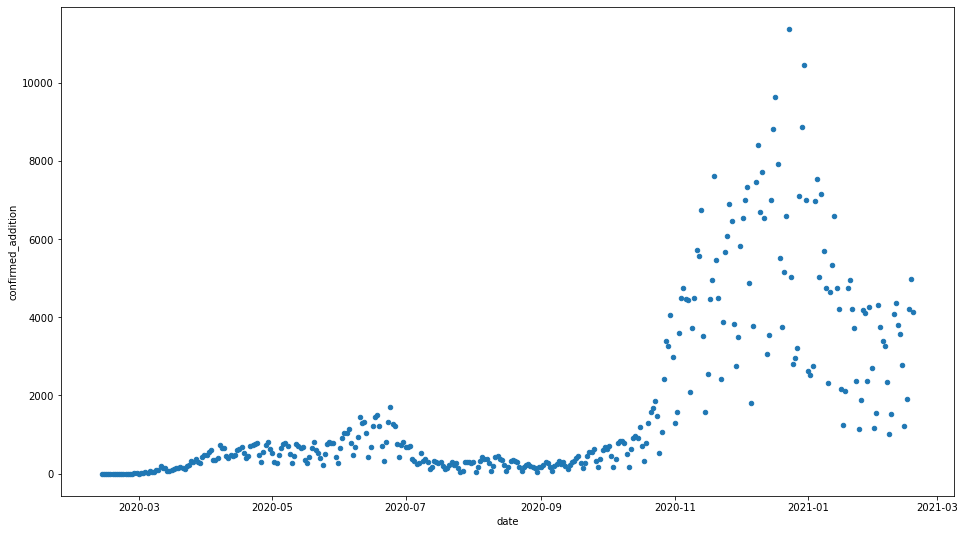

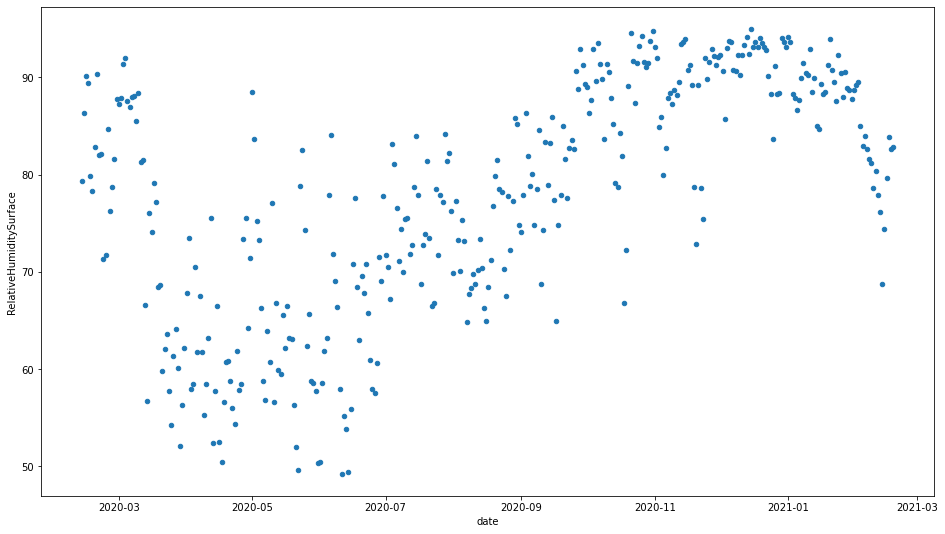

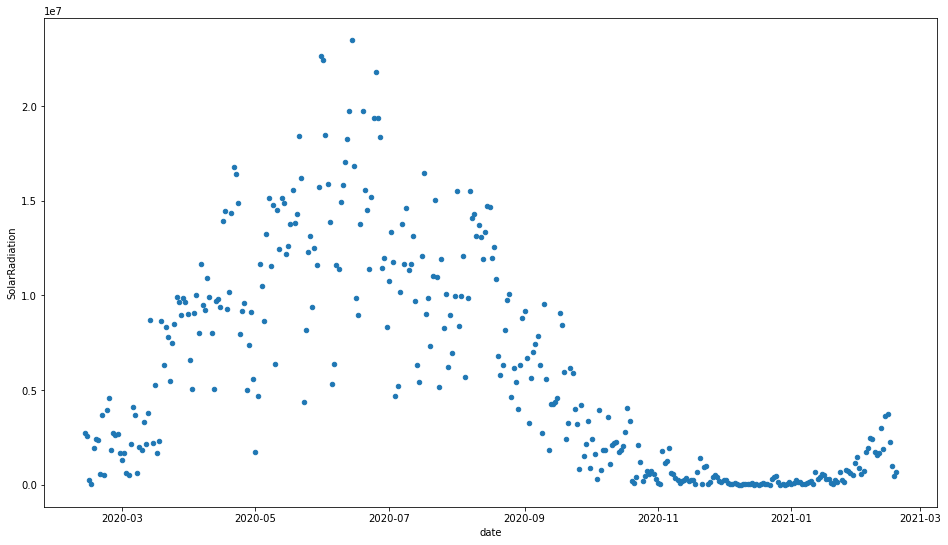

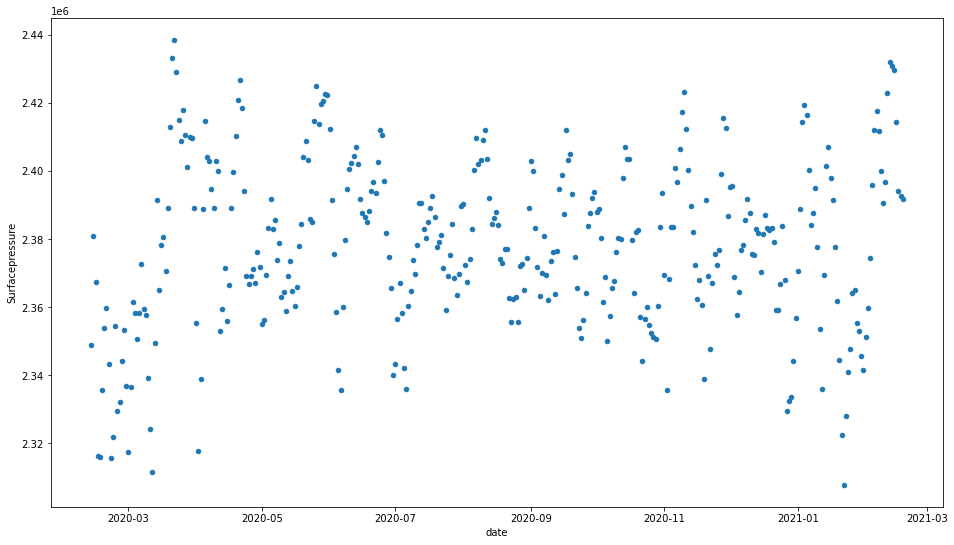

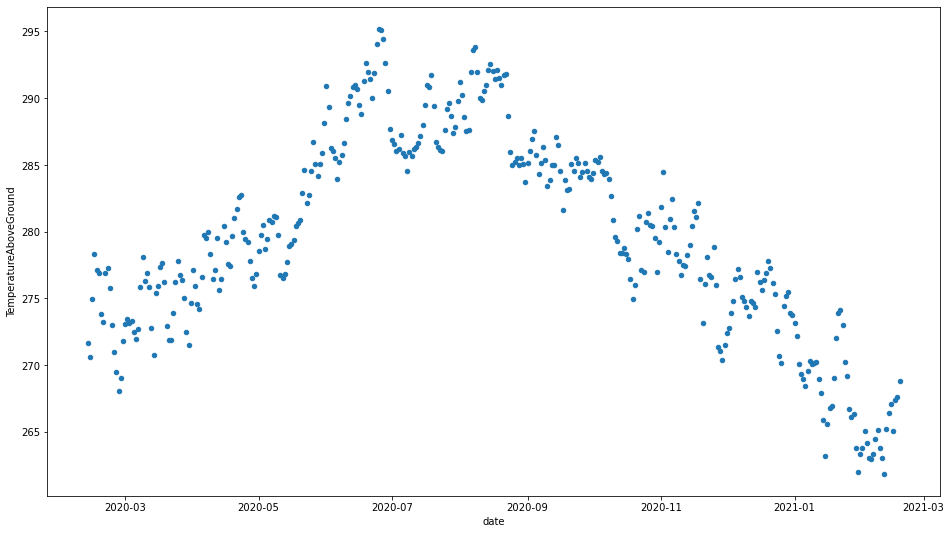

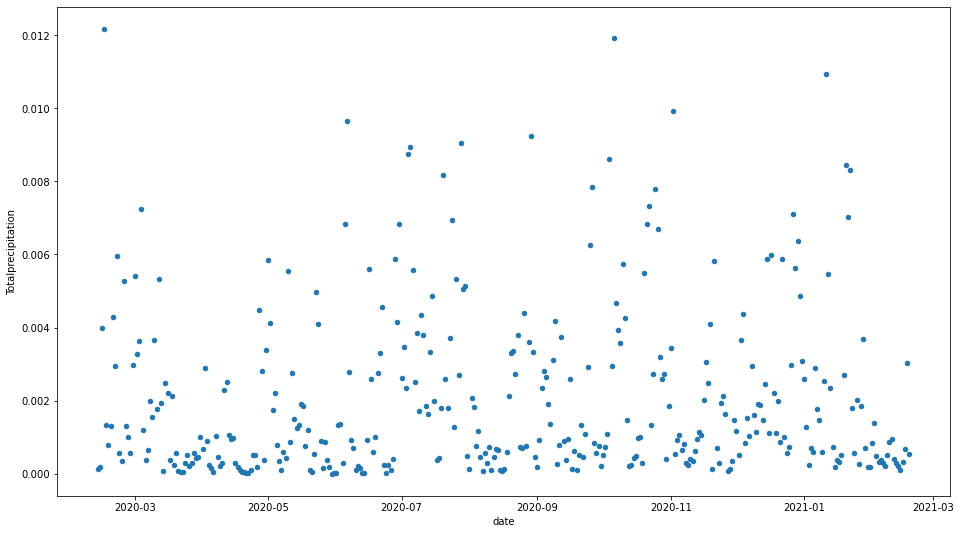

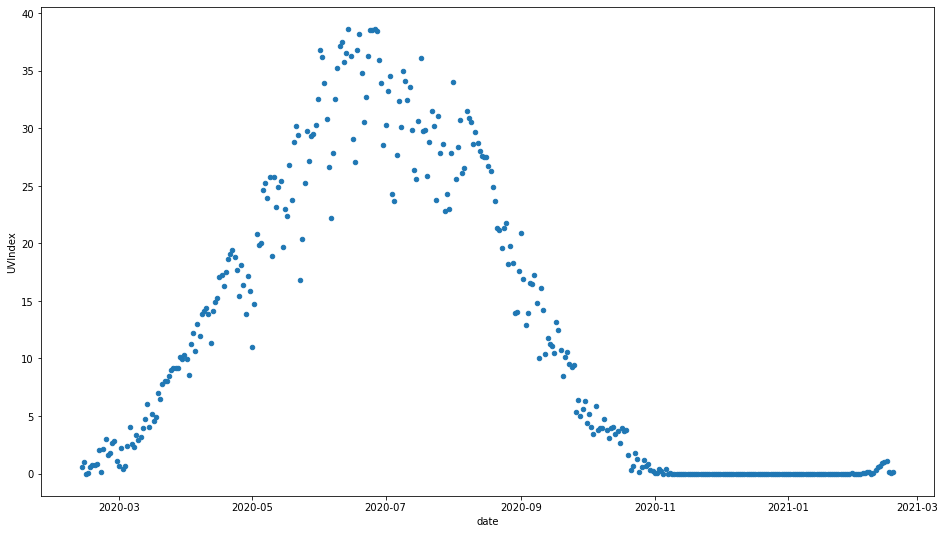

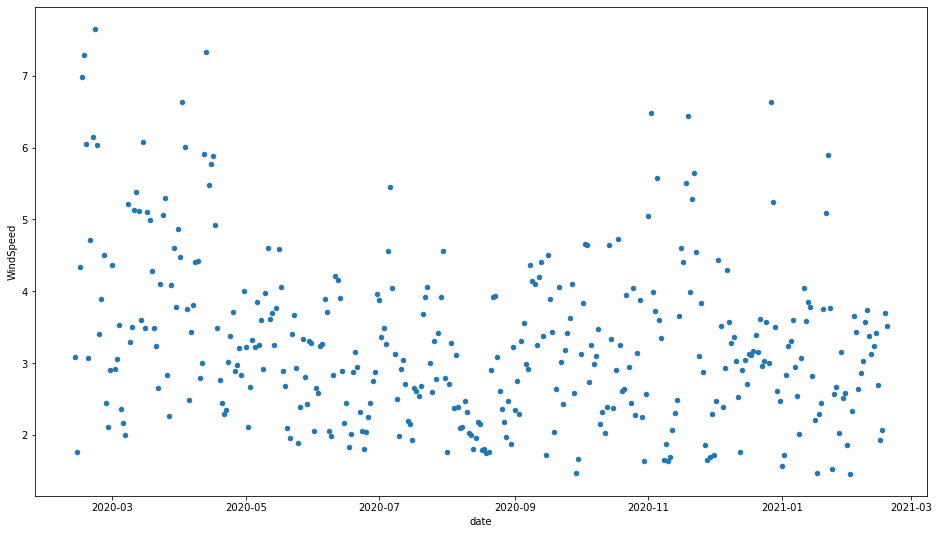

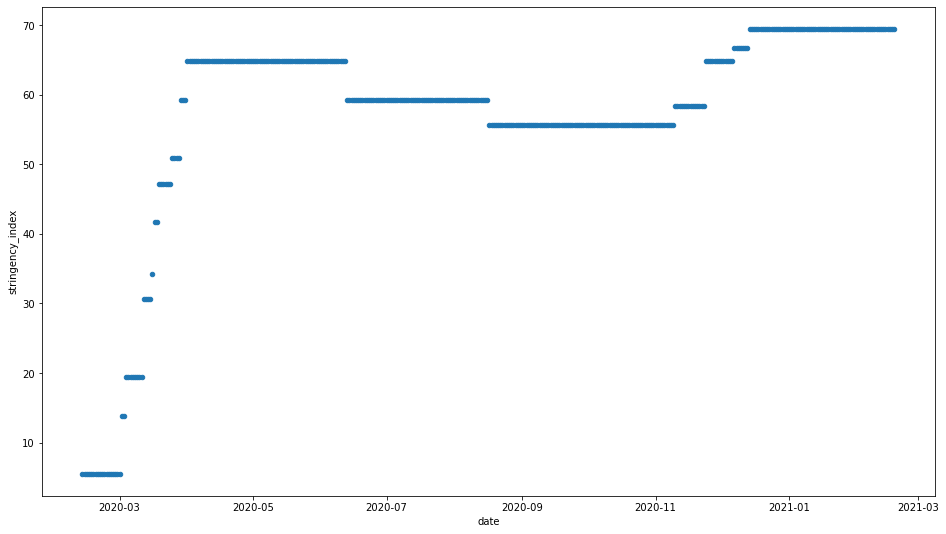

In [10]:
xs = "date"
ys = ['confirmed_addition', 'RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure',
       'TemperatureAboveGround', 'Totalprecipitation', 'UVIndex', 'WindSpeed',
       'stringency_index']

# N to N plots of variable on a given day 
for y in ys:
    SE_dataset_by_date.plot(xs,y, figsize=(16,9), kind="scatter")

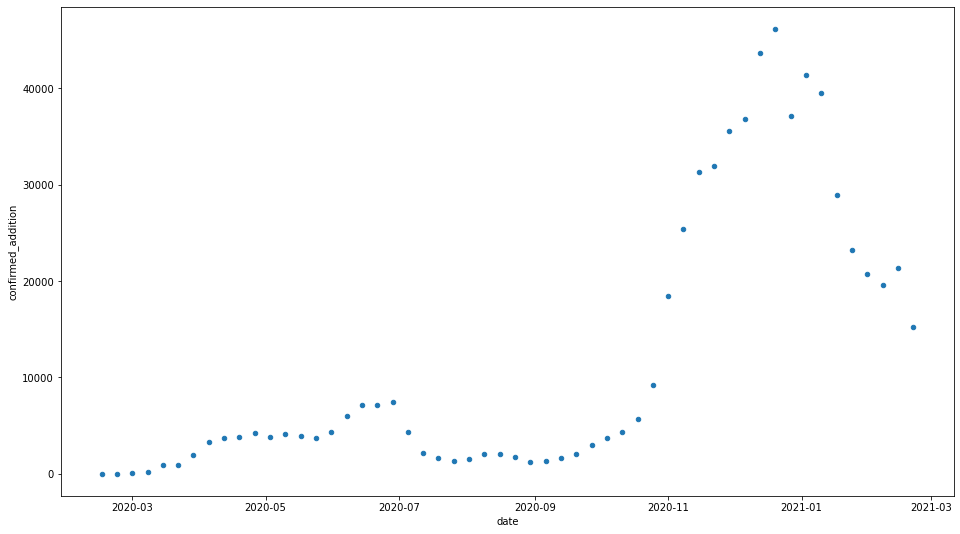

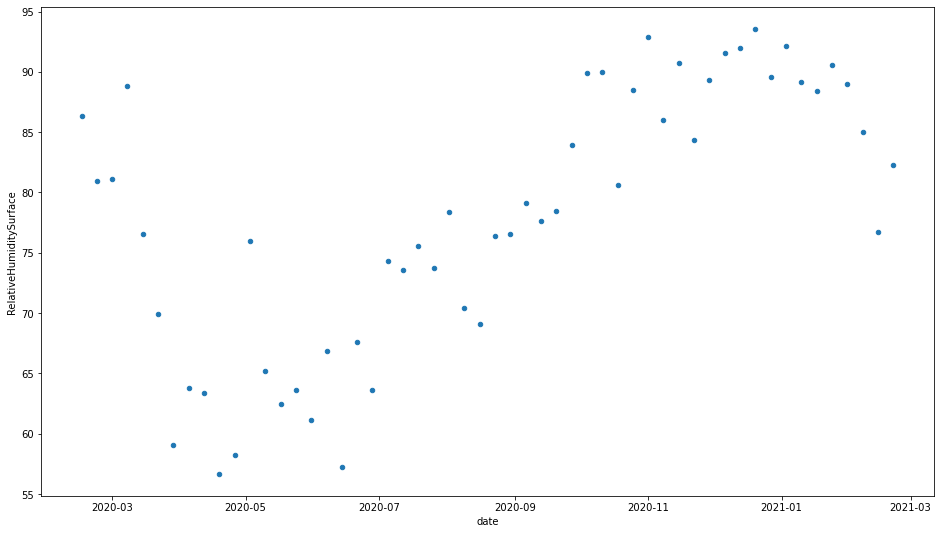

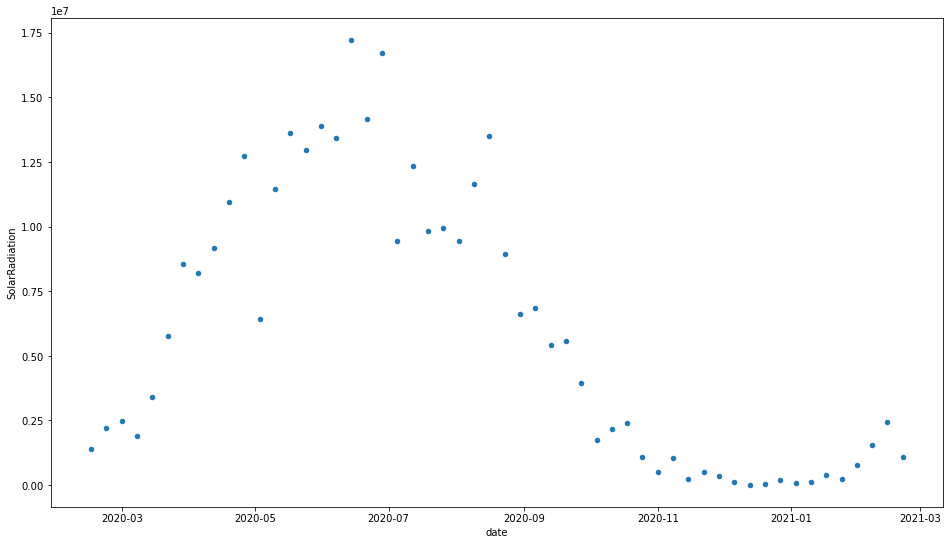

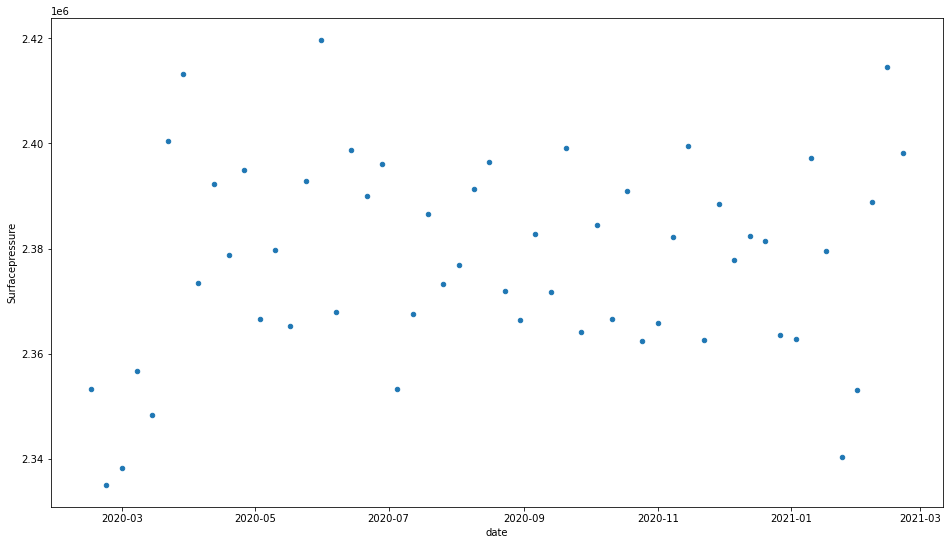

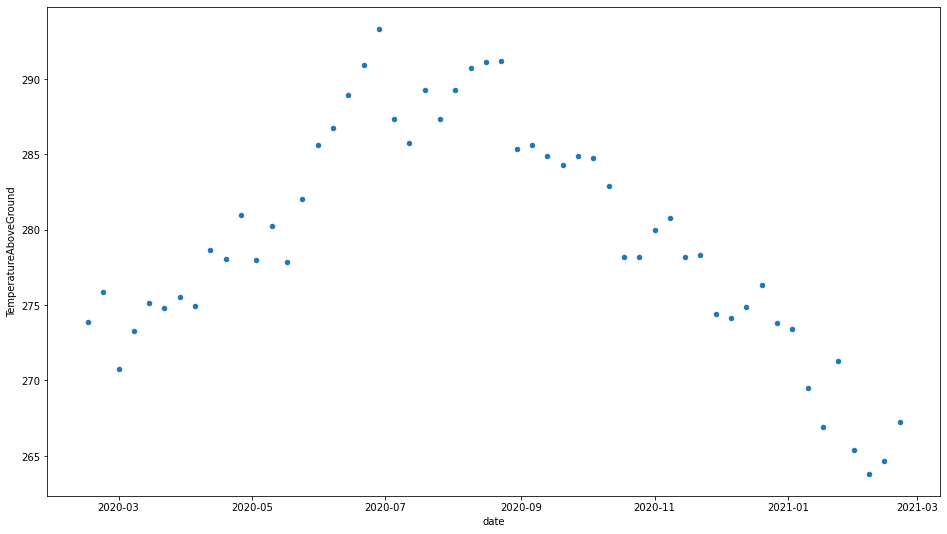

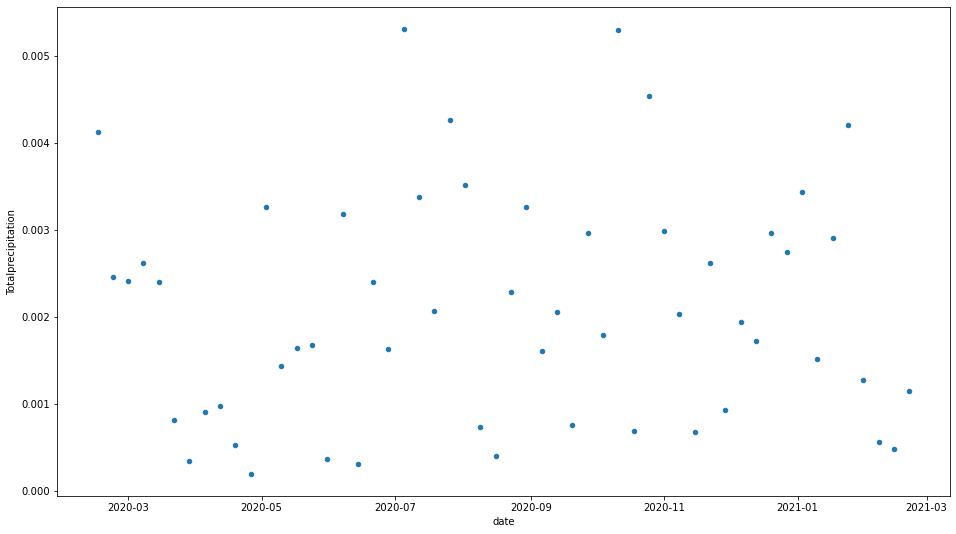

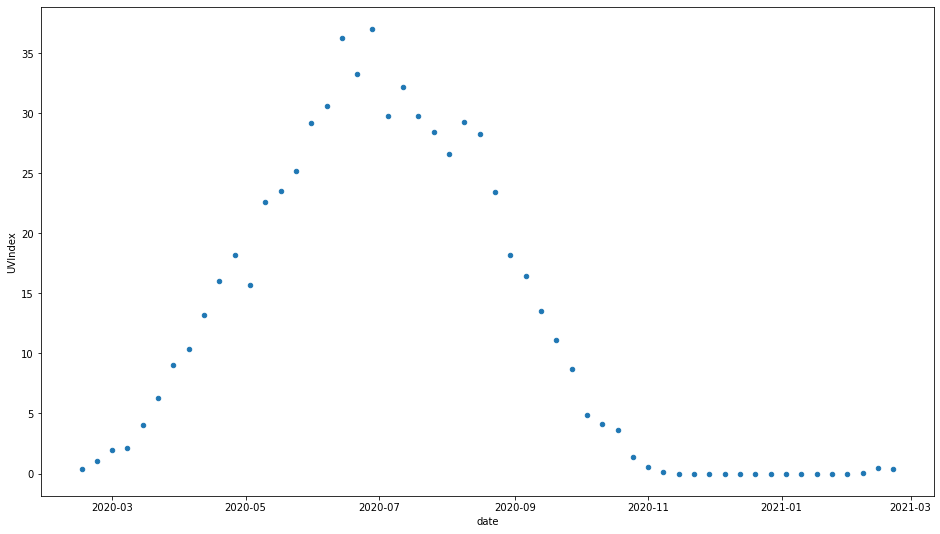

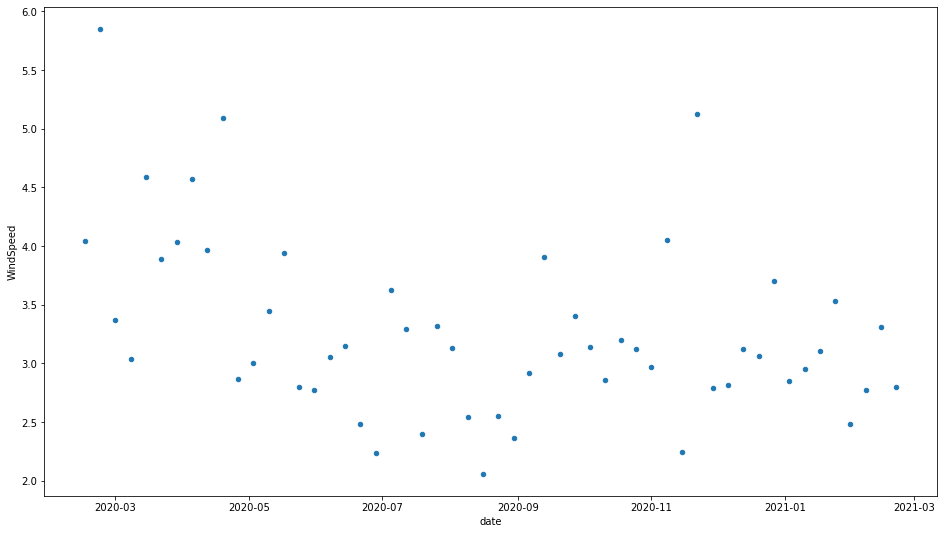

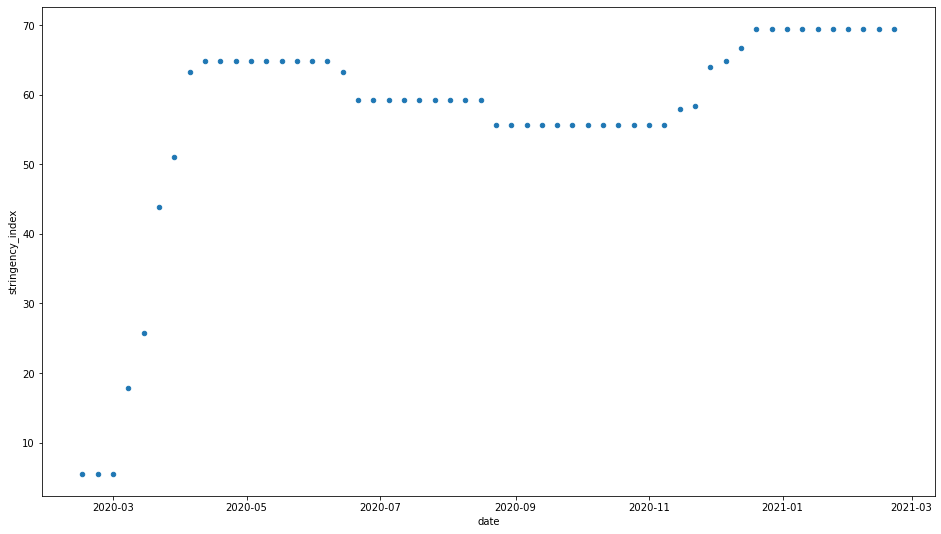

In [11]:
'''Plots of cases and weather for the whole country, aggregated weekly'''


xs = "date"
ys = [ 'confirmed_addition', 'RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure',
       'TemperatureAboveGround', 'Totalprecipitation', 'UVIndex', 'WindSpeed',
       'stringency_index']


# N to N plots of variable on a given day 
for y in ys:
    SE_dataset_by_week.plot(xs,y, figsize=(16,9), kind="scatter")

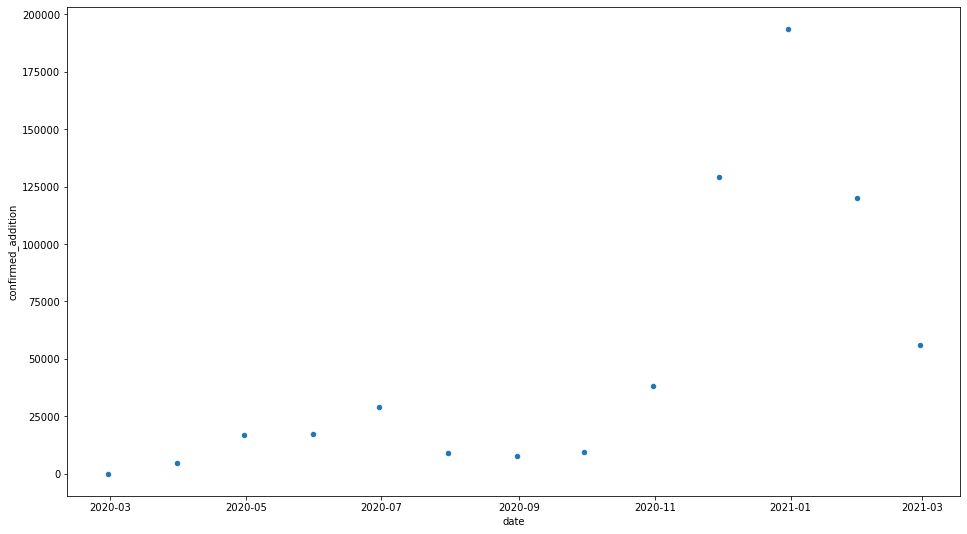

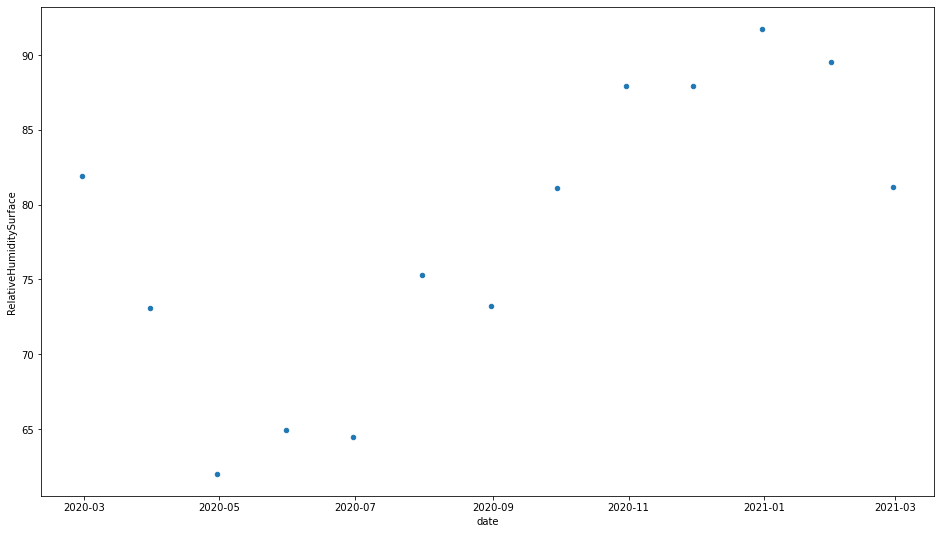

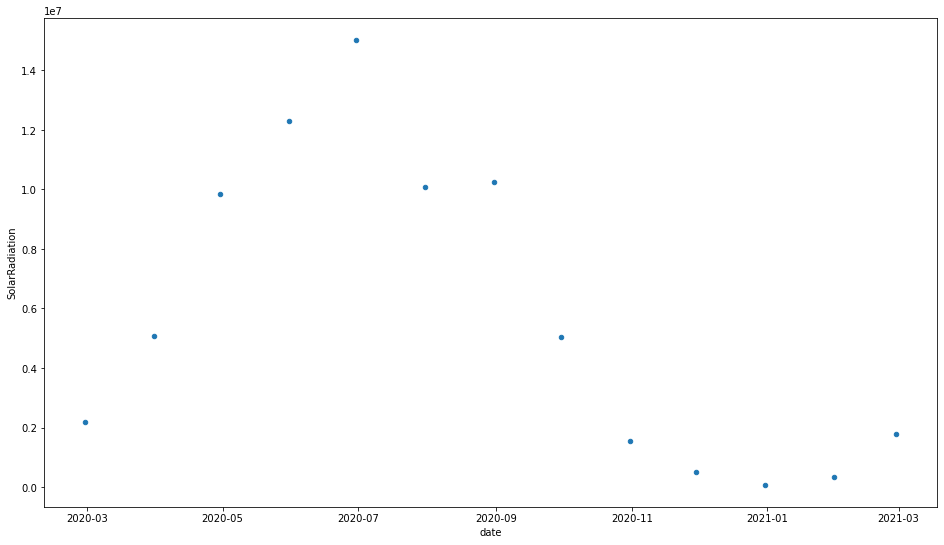

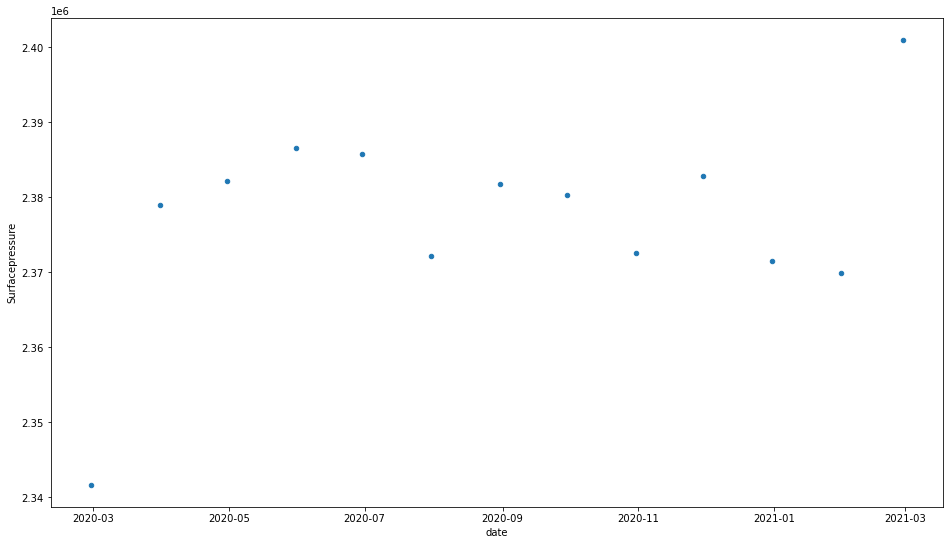

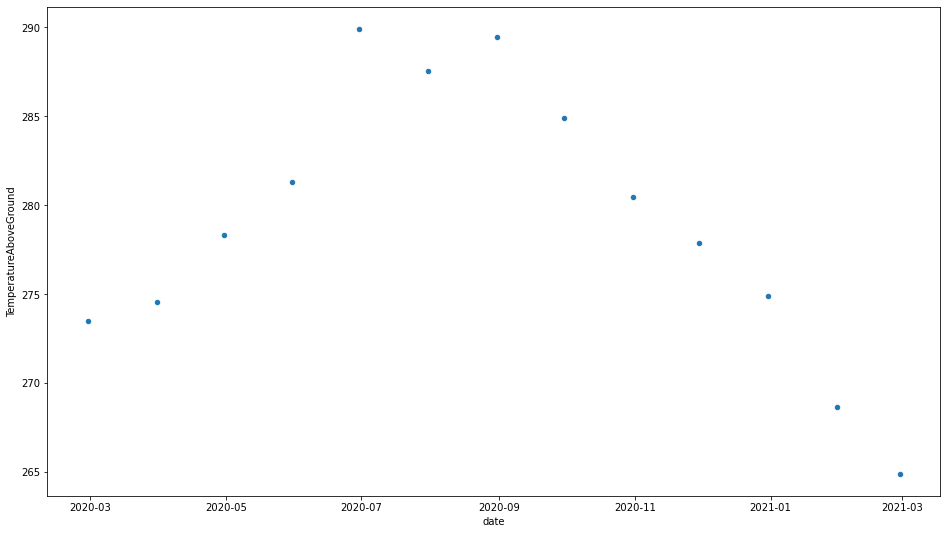

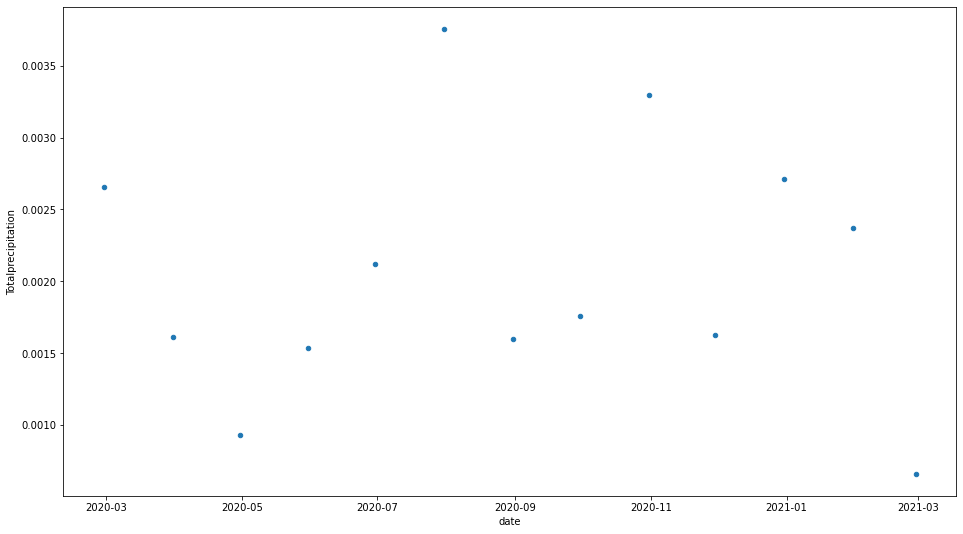

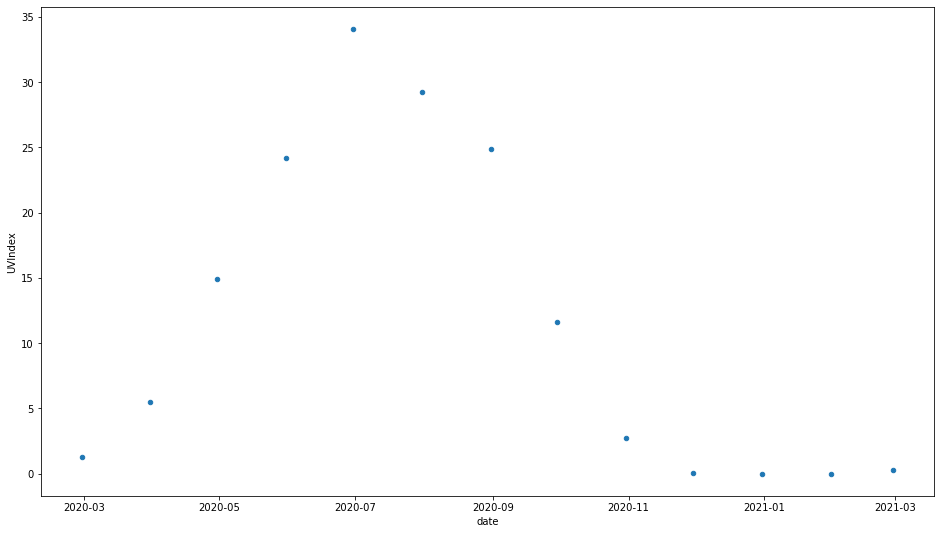

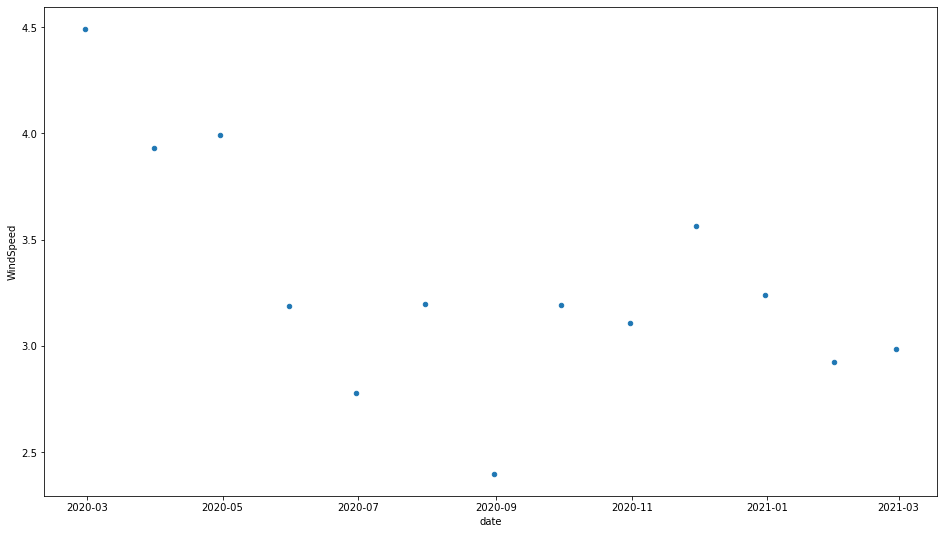

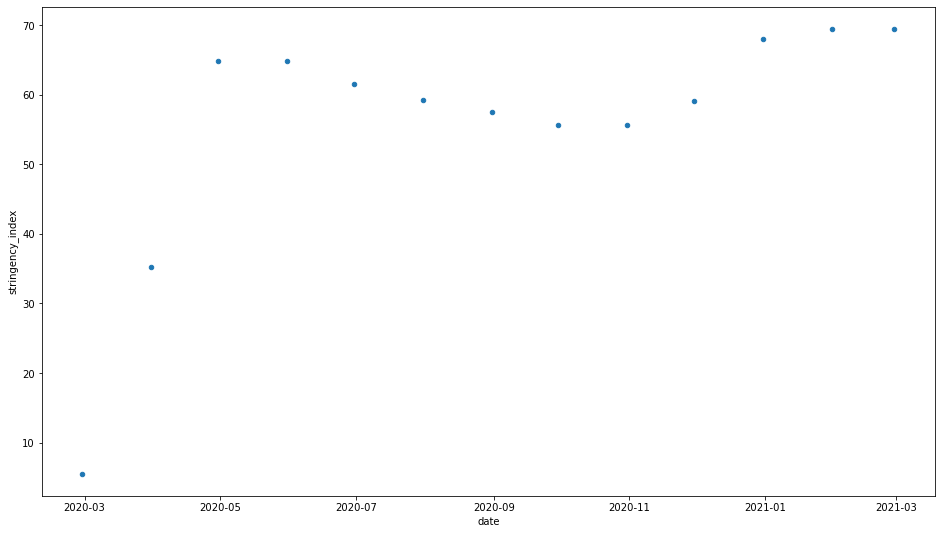

In [12]:
'''Plots of cases and weather for the whole country, aggregated monthly'''


xs = "date"
ys = [ 'confirmed_addition', 'RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure',
       'TemperatureAboveGround', 'Totalprecipitation', 'UVIndex', 'WindSpeed',
       'stringency_index']


# N to N plots of variable on a given day 
for y in ys:
    SE_dataset_by_month.plot(xs,y, figsize=(16,9), kind="scatter")

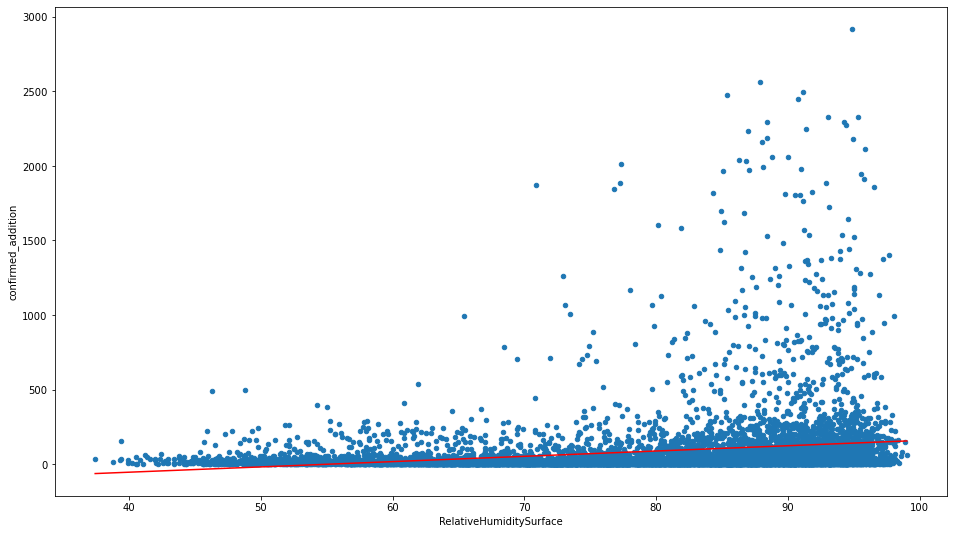

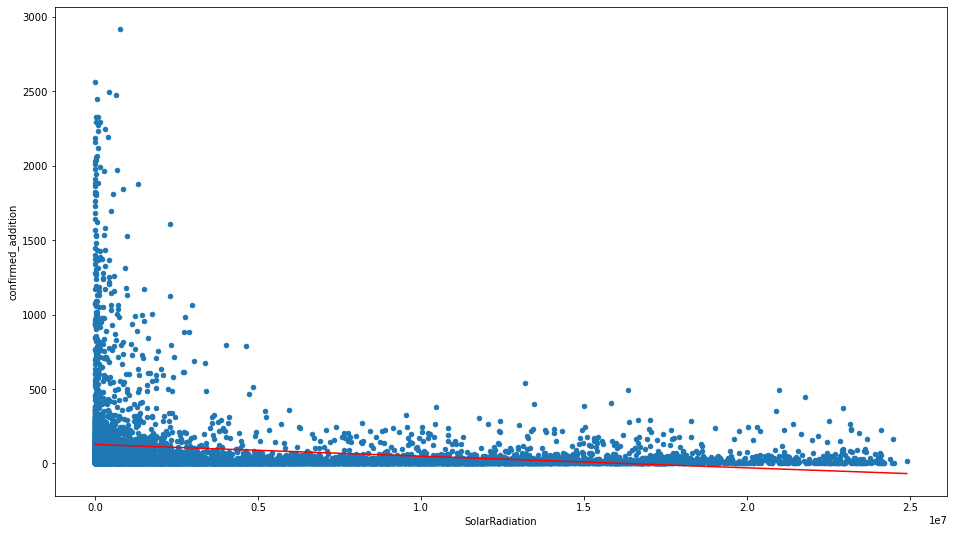

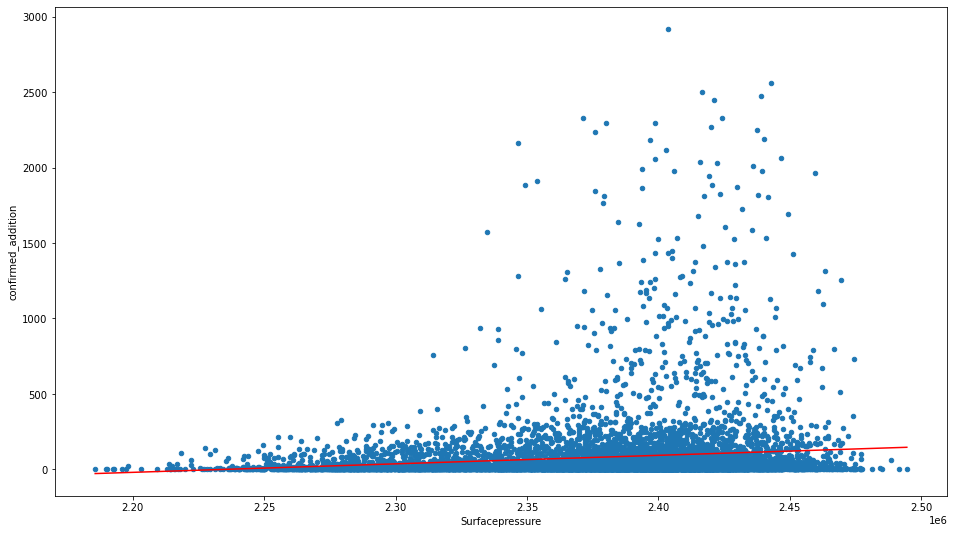

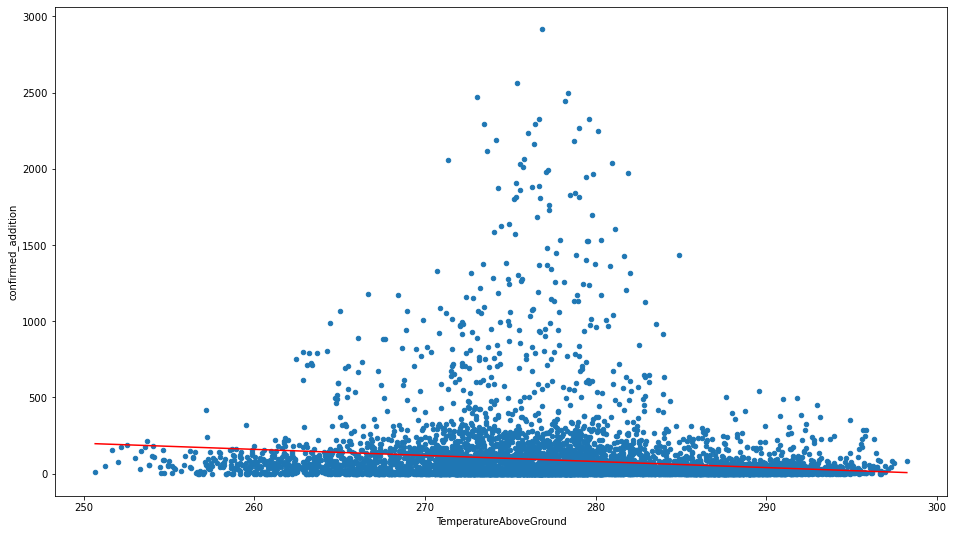

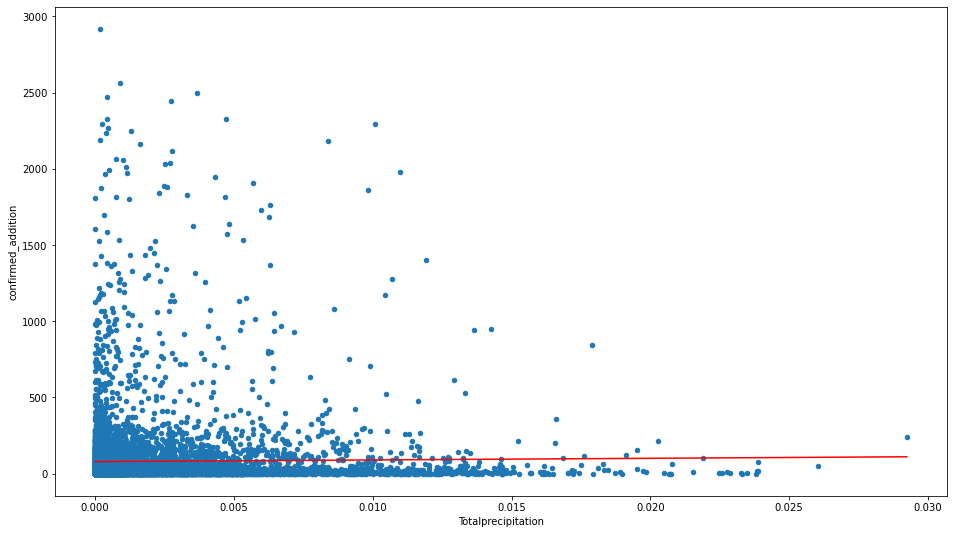

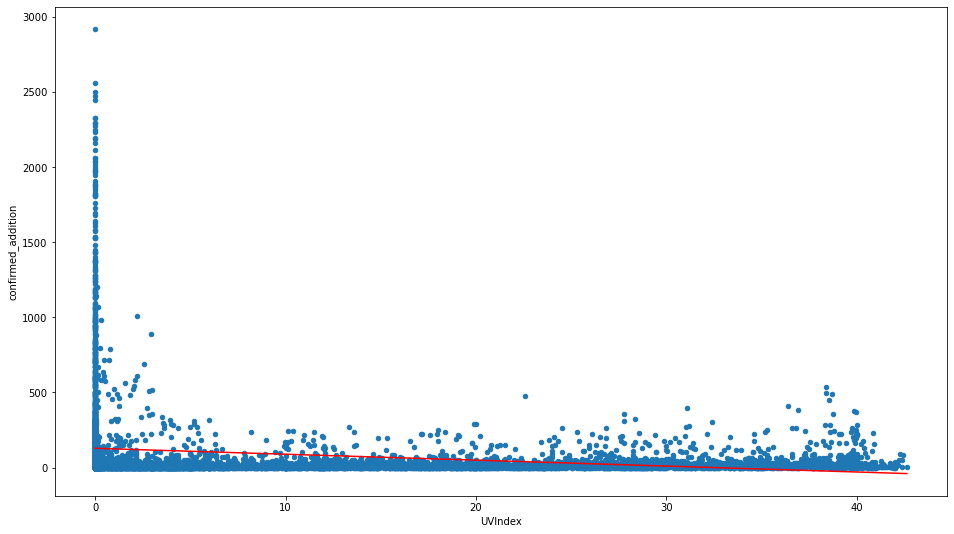

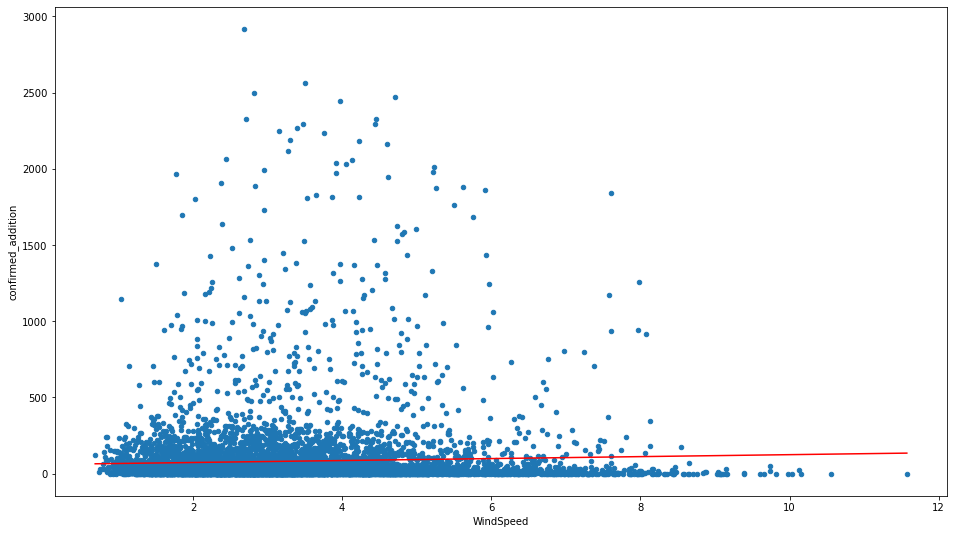

In [13]:
# N to N plot of cases against weather variables
# need to loc values on dates 



xs = 'confirmed_addition'
ys = ['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure',
       'TemperatureAboveGround', 'Totalprecipitation', 'UVIndex', 'WindSpeed']


for y in ys:
    ax = SE_dataset.plot(y, xs, figsize=(16,9), kind = "scatter")
    min_x= np.min(SE_dataset[y])
    max_x= np.max(SE_dataset[y])

    slope, intercept, _,_,_ = linregress(SE_dataset[y],SE_dataset[xs])
    
    x1=np.linspace(min_x, max_x)
    y1=slope*x1+intercept
    plt.plot(x1,y1,'-r')
    
    
    
 

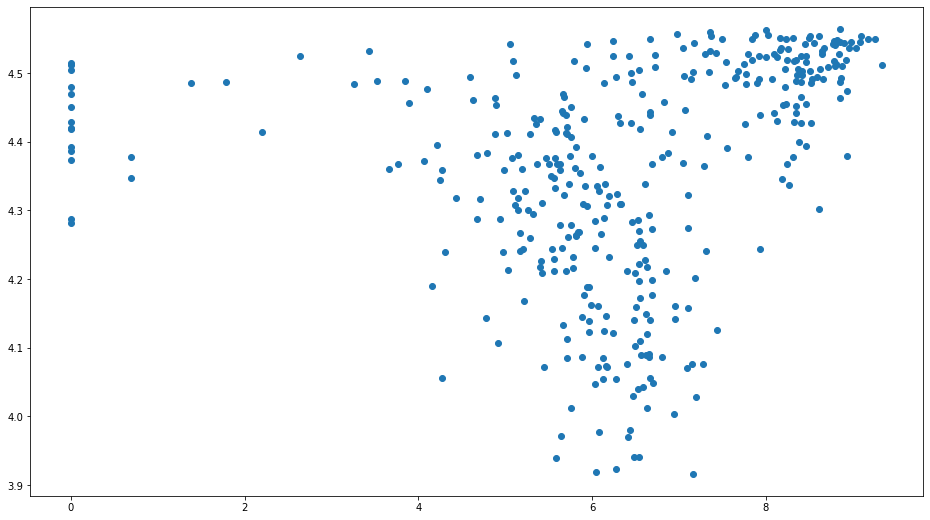

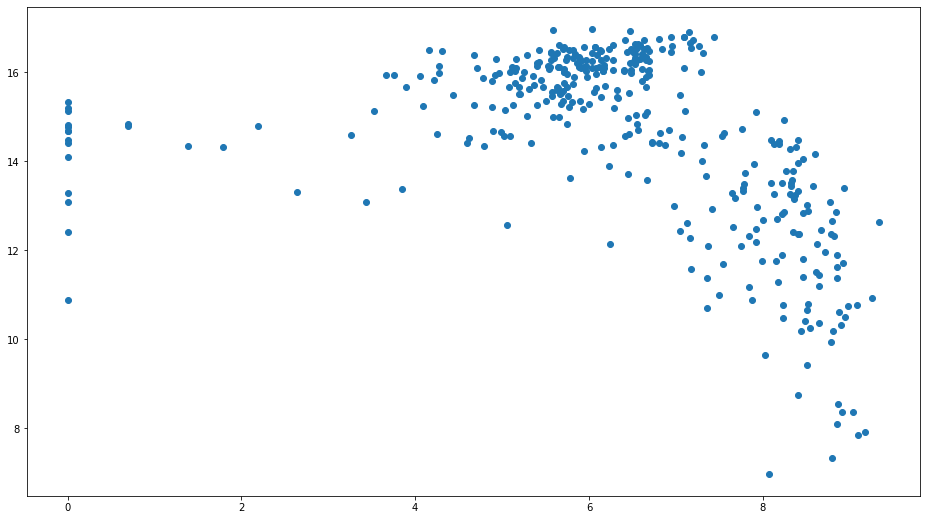

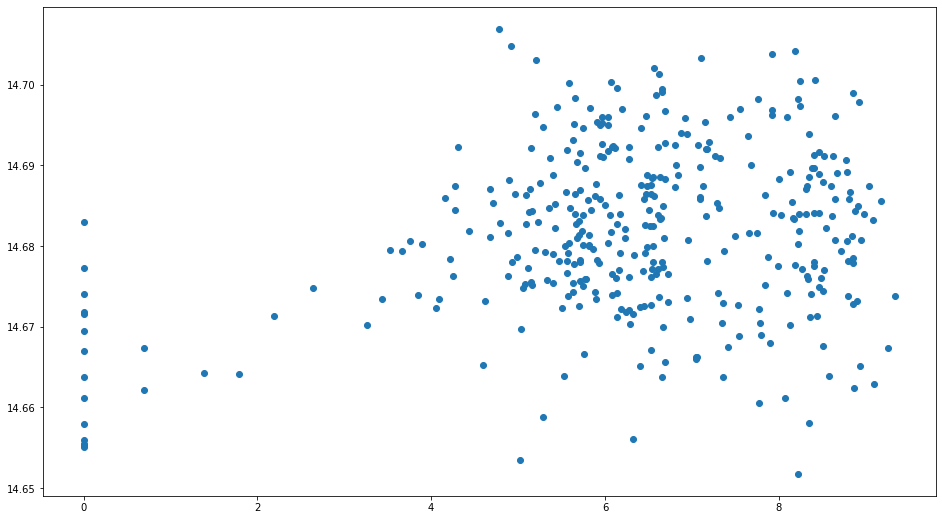

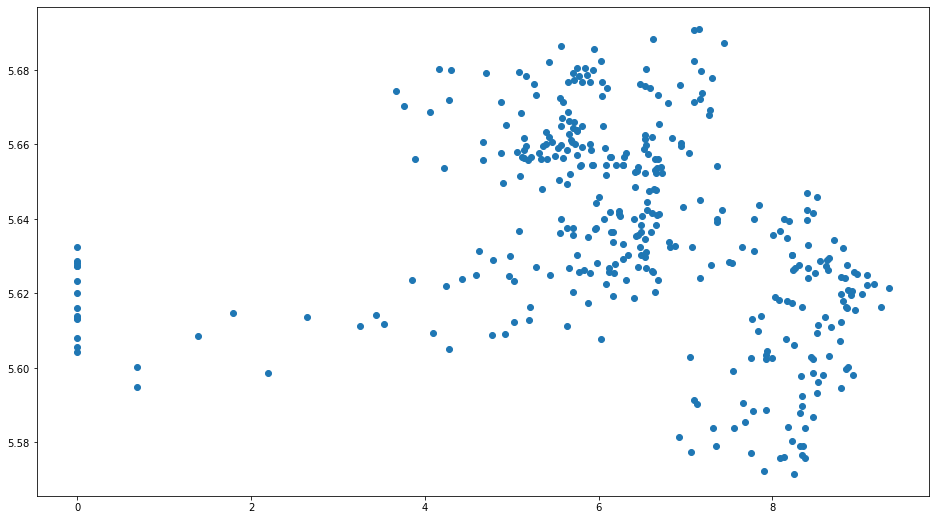

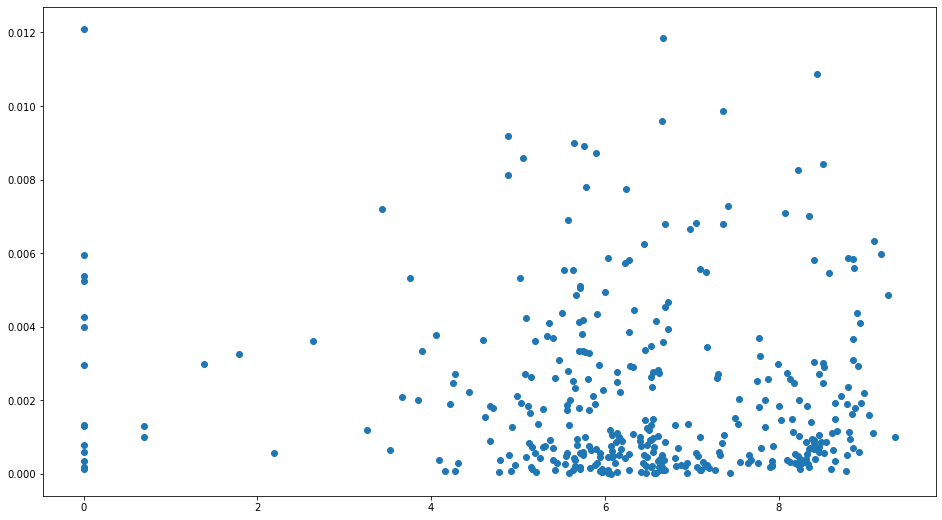

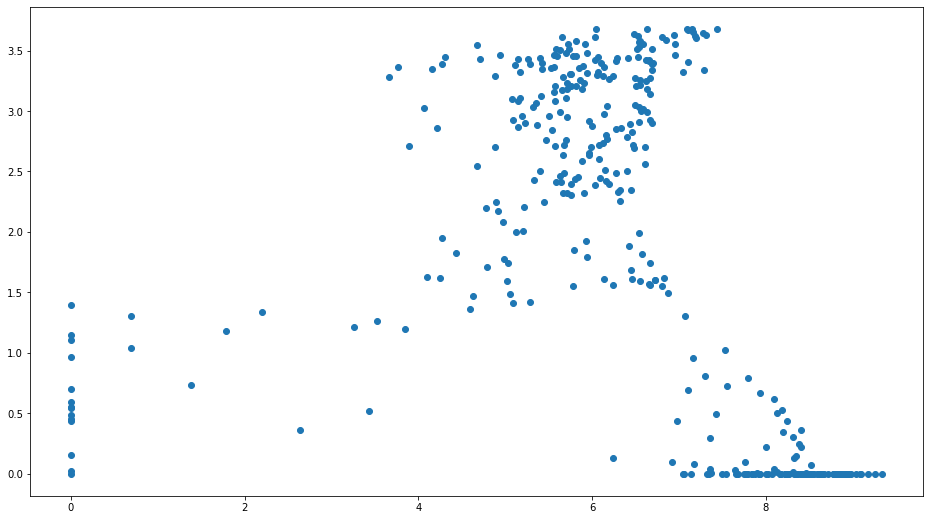

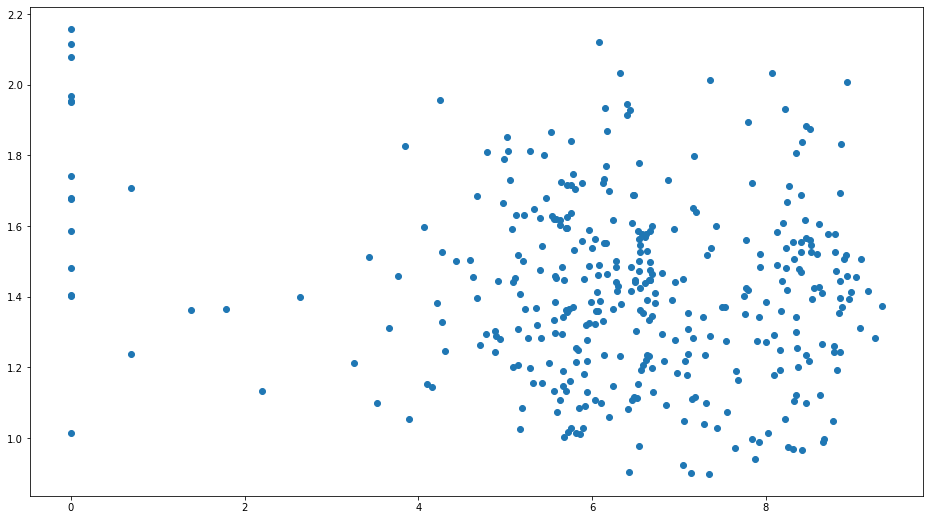

In [14]:
# log to log plots 
for y in ys:
    fig = plt.figure(figsize=(16,9))
    plt.scatter(np.log(SE_dataset_by_date[xs]+1),np.log(SE_dataset_by_date[y]+1))
    plt.show()

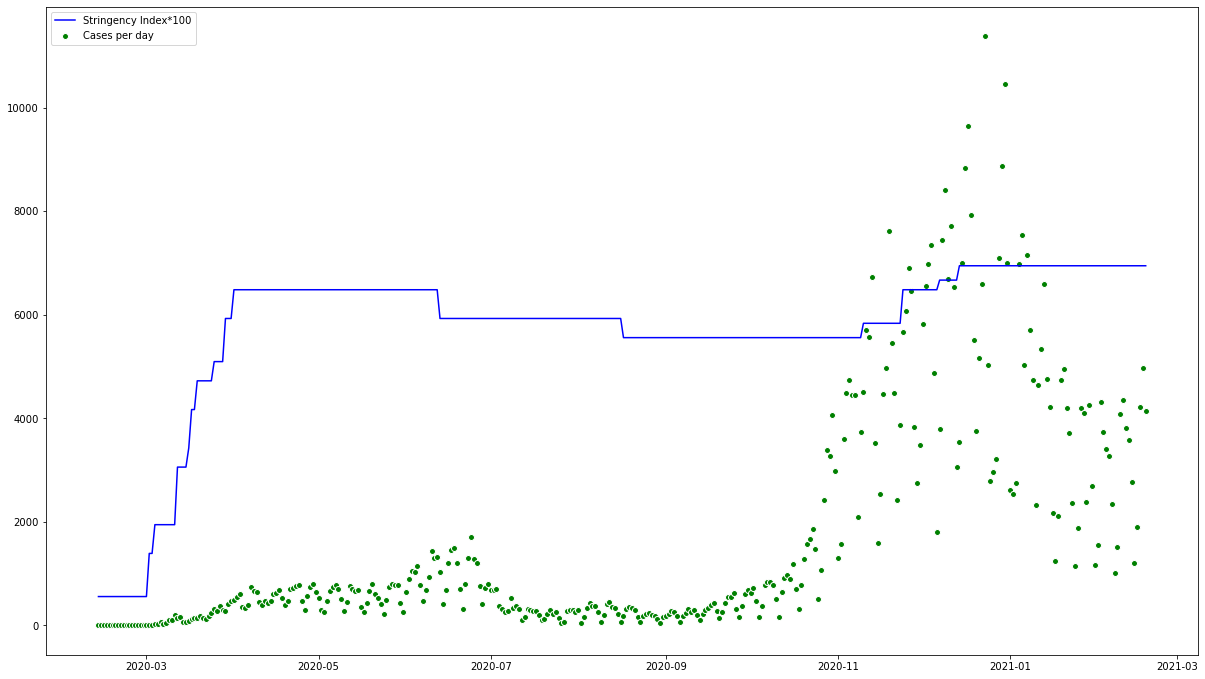

In [15]:
''''''

fig = plt.figure(figsize=(16, 9))
axes = fig.add_axes([0, 0, 1, 1])

axes.scatter(SE_dataset_by_date['date'], SE_dataset_by_date['confirmed_addition'], color="green", label="Cases per day", edgecolors="w")
axes.plot(SE_dataset_by_date['date'], SE_dataset_by_date['stringency_index']*100, color="blue", label="Stringency Index*100")

axes.legend(loc="upper left")

plt.show()







<h2> Task 2: Associations  </h2>

<b> Task description: </b> 

Research whether there is a significant statistical association in your country between weather data and infection rates. Report whether there is a statistically significant association between your chosen variables or not, together with the appropriate statistical metric(s). Discuss why this association, or the lack of this association, is relevant for policies.

In [16]:
#OLS

variables  = SE_dataset.columns[5:12]
# N to N not clustered 

est = OLS(SE_dataset['confirmed_addition'], SE_dataset[variables],hasconst = True).fit()
print(est.summary())



                            OLS Regression Results                            
Dep. Variable:     confirmed_addition   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     169.8
Date:                Tue, 01 Mar 2022   Prob (F-statistic):          1.07e-203
Time:                        14:20:03   Log-Likelihood:                -52744.
No. Observations:                7812   AIC:                         1.055e+05
Df Residuals:                    7805   BIC:                         1.056e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
SolarRadiation         -4.12

In [17]:
# Log to N not clustered

est_log_N = OLS(np.log(SE_dataset['confirmed_addition']+1), SE_dataset[variables],hasconst = True).fit()
print(est_log_N.summary())

                            OLS Regression Results                            
Dep. Variable:     confirmed_addition   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     858.3
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:20:03   Log-Likelihood:                -13858.
No. Observations:                7812   AIC:                         2.773e+04
Df Residuals:                    7805   BIC:                         2.778e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
SolarRadiation         -3.61

In [18]:
# log to log not clustered 
                
est_log_log = OLS(np.log(SE_dataset['confirmed_addition']+1),np.log(SE_dataset[variables]+1),hasconst = True).fit()

print(est_log_log.summary())
                

                            OLS Regression Results                            
Dep. Variable:     confirmed_addition   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     980.2
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:20:03   Log-Likelihood:                -13643.
No. Observations:                7812   AIC:                         2.730e+04
Df Residuals:                    7805   BIC:                         2.735e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
SolarRadiation            -0

In [19]:
# log to log clustered 
                
est_log_log_c = OLS(np.log(SE_dataset['confirmed_addition']+1),np.log(SE_dataset[variables]+1),hasconst = True).fit(cov_type = "cluster", cov_kwds = {"groups": SE_dataset["iso3166-2"]}, use_t = True)

print(est_log_log_c.summary())

                            OLS Regression Results                            
Dep. Variable:     confirmed_addition   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 01 Mar 2022   Prob (F-statistic):                nan
Time:                        14:20:03   Log-Likelihood:                -13643.
No. Observations:                7812   AIC:                         2.730e+04
Df Residuals:                    7805   BIC:                         2.735e+04
Df Model:                           6                                         
Covariance Type:              cluster                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
SolarRadiation            -0

In [20]:
# region fixed effects clustered

SE_variables2  = SE_dataset_fixed_effects.columns[5:30].tolist()
SE_variables2.append('const')

est_xd = OLS(np.log(SE_dataset_fixed_effects["confirmed_addition"] + 1), SE_dataset_fixed_effects[SE_variables2], hasconst = True).fit(cov_type = "cluster", cov_kwds = {"groups": SE_dataset_fixed_effects["iso3166-2"]}, use_t = True)
print(est_xd.summary())

                            OLS Regression Results                            
Dep. Variable:     confirmed_addition   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                 1.754e+04
Date:                Tue, 01 Mar 2022   Prob (F-statistic):           5.81e-37
Time:                        14:20:03   Log-Likelihood:                -12741.
No. Observations:                7812   AIC:                         2.553e+04
Df Residuals:                    7786   BIC:                         2.572e+04
Df Model:                          25                                         
Covariance Type:              cluster                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface   

C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 25, but rank is 9
  warnings.warn('covariance of constraints does not have full '


In [21]:
# region fixed effects clustered logs
est_xd_logs = OLS(np.log(SE_dataset_fixed_effects["confirmed_addition"] + 1),np.log( SE_dataset_fixed_effects[SE_variables2]+1), hasconst = True).fit(cov_type = "cluster", cov_kwds = {"groups": SE_dataset_fixed_effects["iso3166-2"]}, use_t = True)
print(est_xd_logs.summary())

                            OLS Regression Results                            
Dep. Variable:     confirmed_addition   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                 8.110e+11
Date:                Tue, 01 Mar 2022   Prob (F-statistic):          1.30e-113
Time:                        14:20:03   Log-Likelihood:                -12244.
No. Observations:                7812   AIC:                         2.454e+04
Df Residuals:                    7786   BIC:                         2.472e+04
Df Model:                          25                                         
Covariance Type:              cluster                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface   

C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 25, but rank is 9
  warnings.warn('covariance of constraints does not have full '


 <h2> Task 3: Map visualization  </h2>

<b> Task description: </b> 

Visualize a selection of important variables on a map of your country.

<h3> Visualizing the hospitalizations due to COVID-19 </h3>

In [23]:
geo_json_path = '../data/raw/shapefiles/se.geojson'
SE_cases_map = folium.Map(location = [63,14], zoom_start = 4.13, crs = 'EPSG3857')

folium.Choropleth(
    geo_data = geo_json_path,
    name = 'Cases',
    data = SE_corona_by_region,
    columns = ['iso3166-2', 'confirmed_addition'],
    key_on = 'properties.iso_3166_2',
    fill_color = 'YlOrRd',
    fill_opacity = 0.5,
    line_opacity = 0.3,
    legend_name = 'Infected',
).add_to(SE_cases_map)

SE_cases_map

<h3> Visualizing the hospitalizations due to COVID-19 per capita</h3>

In [24]:
SE_corona_by_region['admitted_per_capita'] = SE_corona_by_region['confirmed_addition'] / SE_corona_by_region['population'] 
  
SE_cases_capita_map = folium.Map(location = [63,14], zoom_start = 4, crs = 'EPSG3857')

folium.Choropleth(
    geo_data = geo_json_path,
    name = 'Cases',
    data = SE_corona_by_region,
    columns = ['iso3166-2', 'admitted_per_capita'],
    key_on = 'properties.iso_3166_2',
    fill_color = 'YlGn',
    fill_opacity = 0.5,
    line_opacity = 0.3,
    legend_name = 'Admitted per capita',
).add_to(SE_cases_capita_map)

SE_cases_capita_map

 <h2> Task 4: Open question  </h2>

<b> Task description: </b> 

Use the data to formulate, motivate, answer, and discuss another research question of your choice. For example, compare your country to another one in the dataset; or investigate additional variables that you could find elsewhere (e.g. total population, population density, population demographics such as age distribution, number of elders, etc); or identify if there are temporal patterns (is one variable more important in some months? Are weekends different from weekdays? Etc), ...

<h3> Comparing Sweden to Germany </h3>

In [25]:

DE_weather = weather_data[weather_data['iso3166-2'].str.startswith('DE')]

DE_weather

,date,iso3166-2,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed
0,2020-02-13,DE-BB,76.337444,1.824290e+06,2.403341e+06,276.551573,0.003355,2.777806,4.542822
1,2020-02-13,DE-BE,76.065297,1.786373e+06,2.408182e+06,276.844633,0.003523,4.671329,4.761509
2,2020-02-13,DE-BW,80.113988,1.505760e+06,2.290158e+06,276.227143,0.008013,4.268546,4.467024
3,2020-02-13,DE-BY,81.554346,2.363013e+06,2.275361e+06,275.583053,0.005227,4.417797,3.677414
4,2020-02-13,DE-HB,87.167414,8.389756e+03,2.406940e+06,276.237452,0.007715,1.794872,4.699573
...,...,...,...,...,...,...,...,...,...
20182,2021-02-21,DE-SH,78.077610,5.698494e+06,2.431487e+06,281.943486,0.000000,4.474084,2.532838
20183,2021-02-21,DE-SL,60.483775,8.762859e+06,2.350492e+06,283.516066,0.000000,8.000000,3.247090
20184,2021-02-21,DE-SN,74.638170,6.687276e+06,2.363996e+06,279.277820,0.000008,5.409593,4.648033
20185,2021-02-21,DE-ST,69.587170,7.276057e+06,2.408002e+06,282.418775,0.000000,5.273630,2.972845


In [26]:
'''Smaller datasets, if neccessary'''
DE_weather_by_region = DE_weather.groupby(by = 'iso3166-2').agg(['min','mean','median','max'])
DE_weather_by_date = DE_weather.groupby(by = 'date').mean()

In [27]:
'''Importing the data about hospitalizations due to COVID-19'''
DE_corona = pd.read_csv('../data/raw/corona/de_corona.csv', sep = '\t', encoding = 'utf-8')
print('Empty cells: ',DE_corona.isna().any().any()) #checking if the file has empty cells

del DE_corona['deceased_addition']

'''Keeping only the dates that are present in the Swedish corona data'''
print('Shape before: ', DE_corona.shape)

DE_corona = DE_corona[DE_corona['date'].isin(SE_corona['date'])]

print('Shape after: ', DE_corona.shape)
print()
print('First day Germany dataset: ', min(DE_corona['date']))
print('First day Sweden dataset: ', min(SE_corona['date']))
print('Last day Germany dataset: ', max(DE_corona['date']))
print('Last day Sweden dataset: ', max(SE_corona['date']))


DE_corona

Empty cells:  False
Shape before:  (5602, 3)
Shape after:  (5543, 3)

First day Germany dataset:  2020-02-04
First day Sweden dataset:  2020-02-04
Last day Germany dataset:  2021-02-18
Last day Sweden dataset:  2021-02-18


,date,region_code,confirmed_addition
14,2020-02-04,Bayern,3
15,2020-02-04,Niedersachsen,1
16,2020-02-06,Bayern,1
17,2020-02-07,Bayern,1
18,2020-02-10,Nordrhein-Westfalen,1
...,...,...,...
5552,2021-02-18,Saarland,111
5553,2021-02-18,Sachsen,510
5554,2021-02-18,Sachsen-Anhalt,372
5555,2021-02-18,Schleswig-Holstein,256


In [28]:
'''Importing the country metadata from a JSON file'''
with open('../data/raw/metadata/de_metadata.json', 'r', encoding = 'utf-8') as file:
    DE_metadata = json.load(file)

'''Importing the shape of country for creating a map'''
with open('../data/raw/shapefiles/de.geojson', 'r', encoding = 'utf-8') as file:
    DE_shape = json.load(file)

In [31]:
'''Creating dataset of additions per region for use for maps'''

'''Creating a dictionary of ISO codes of German regions'''
DE_isocodes_dictionary = {DE_metadata['country_metadata'][i]['covid_region_code'] : DE_metadata['country_metadata'][i]['iso3166-2_code'] for i in range(len(DE_metadata['country_metadata']))}
DE_corona['iso3166-2'] = DE_corona['region_code'].map(DE_isocodes_dictionary)
DE_corona_by_region = DE_corona.groupby(by = 'iso3166-2')['confirmed_addition'].sum().reset_index()

'''Creating a dictionary of ISO codes of regions and their population'''
DE_isocode_population = {DE_metadata['country_metadata'][i]['iso3166-2_code'] : DE_metadata['country_metadata'][i]['population'] for i in range(len(DE_metadata['country_metadata']))}
DE_corona_by_region['population'] = DE_corona_by_region['iso3166-2'].map(DE_isocode_population)

DE_corona_by_region

,iso3166-2,confirmed_addition,population
0,DE-BB,74397,2511917
1,DE-BE,126384,3644826
2,DE-BW,309273,11069533
3,DE-BY,426174,13076721
4,DE-HB,17263,682986
5,DE-HE,183132,6265809
6,DE-HH,49922,1841179
7,DE-MV,23101,1609675
8,DE-NI,157412,7982448
9,DE-NW,517284,17932651


In [34]:
'''Loading the Our World in Data datases''' 


DE_stringency_index = stringency_index[stringency_index["iso_code"] == "DEU"][["date", "stringency_index"]].dropna()
DE_stringency_index = DE_stringency_index[DE_stringency_index['date'].isin(DE_corona['date'])]
print('Empty cells after dropping NAs: ',DE_stringency_index.isna().any().any())

DE_stringency_index

Empty cells after dropping NAs:  False


,date,stringency_index
56149,2020-02-04,5.56
56151,2020-02-06,5.56
56152,2020-02-07,5.56
56155,2020-02-10,5.56
56156,2020-02-11,5.56
...,...,...
56525,2021-02-14,83.33
56526,2021-02-15,83.33
56527,2021-02-16,83.33
56528,2021-02-17,83.33


In [37]:
'''Merging weather data and additions data'''
DE_dataset = pd.merge(DE_corona,DE_weather, on = ['iso3166-2','date'])

print('Lost rows from the weather data: ', DE_weather.shape[0] - DE_dataset.shape[0])
print('Lost rows from the additions data: ', DE_corona.shape[0] - DE_dataset.shape[0])


'''Adding stringency index'''
DE_dataset = DE_dataset.merge(DE_stringency_index, on = "date") #regions have the strigency index on the same day

print('Main dataset shape: ', DE_dataset.shape)


DE_dataset['date'] = pd.to_datetime(DE_dataset['date'], format='%Y-%m-%d')

DE_dataset

Lost rows from the weather data:  465
Lost rows from the additions data:  8
Main dataset shape:  (5535, 12)


,date,region_code,confirmed_addition,iso3166-2,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed,stringency_index
0,2020-02-16,Mecklenburg-Vorpommern,1,DE-MV,69.818665,4.562424e+04,2.392858e+06,284.294049,0.004641,0.211216,7.888859,11.11
1,2020-02-17,Brandenburg,1,DE-BB,64.189273,9.007504e+05,2.409194e+06,282.312595,0.001005,2.631685,6.319781,11.11
2,2020-02-18,Brandenburg,1,DE-BB,71.904630,4.042940e+06,2.421421e+06,279.679468,0.002388,4.037911,6.150824,11.11
3,2020-02-20,Nordrhein-Westfalen,1,DE-NW,81.738535,1.064802e+06,2.383996e+06,279.663867,0.006802,3.524003,6.477330,11.11
4,2020-02-24,Baden-Württemberg,1,DE-BW,80.314208,6.604918e+05,2.308155e+06,281.894530,0.005284,5.613589,4.663207,11.11
...,...,...,...,...,...,...,...,...,...,...,...,...
5530,2021-02-18,Saarland,111,DE-SL,82.393963,1.536060e+06,2.344207e+06,279.234115,0.004769,6.203804,3.984330,83.33
5531,2021-02-18,Sachsen,510,DE-SN,76.777255,3.868652e+06,2.356898e+06,279.199627,0.000117,4.893039,3.697715,83.33
5532,2021-02-18,Sachsen-Anhalt,372,DE-ST,78.621462,2.182871e+06,2.401851e+06,279.183997,0.001432,3.299743,3.301214,83.33
5533,2021-02-18,Schleswig-Holstein,256,DE-SH,87.604977,1.773621e+06,2.422251e+06,279.925950,0.005725,2.274352,4.261184,83.33


In [38]:
#data set with region boolean for fixed effects
DE_dataset_fixed_effects = DE_dataset

DE_regions = []

DE_dataset_fixed_effects = smapi.add_constant(DE_dataset_fixed_effects)

for region in set(DE_dataset_fixed_effects["iso3166-2"]):
    if region != "SE-K":
        DE_dataset_fixed_effects[region] = (DE_dataset_fixed_effects["iso3166-2"] == region).astype(int)
        DE_regions.append(region)
        
DE_dataset_fixed_effects

,const,date,region_code,confirmed_addition,iso3166-2,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,...,DE-TH,DE-NW,DE-HH,DE-SL,DE-SN,DE-BB,DE-SH,DE-RP,DE-BE,DE-MV
0,1.0,2020-02-16,Mecklenburg-Vorpommern,1,DE-MV,69.818665,4.562424e+04,2.392858e+06,284.294049,0.004641,...,0,0,0,0,0,0,0,0,0,1
1,1.0,2020-02-17,Brandenburg,1,DE-BB,64.189273,9.007504e+05,2.409194e+06,282.312595,0.001005,...,0,0,0,0,0,1,0,0,0,0
2,1.0,2020-02-18,Brandenburg,1,DE-BB,71.904630,4.042940e+06,2.421421e+06,279.679468,0.002388,...,0,0,0,0,0,1,0,0,0,0
3,1.0,2020-02-20,Nordrhein-Westfalen,1,DE-NW,81.738535,1.064802e+06,2.383996e+06,279.663867,0.006802,...,0,1,0,0,0,0,0,0,0,0
4,1.0,2020-02-24,Baden-Württemberg,1,DE-BW,80.314208,6.604918e+05,2.308155e+06,281.894530,0.005284,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5530,1.0,2021-02-18,Saarland,111,DE-SL,82.393963,1.536060e+06,2.344207e+06,279.234115,0.004769,...,0,0,0,1,0,0,0,0,0,0
5531,1.0,2021-02-18,Sachsen,510,DE-SN,76.777255,3.868652e+06,2.356898e+06,279.199627,0.000117,...,0,0,0,0,1,0,0,0,0,0
5532,1.0,2021-02-18,Sachsen-Anhalt,372,DE-ST,78.621462,2.182871e+06,2.401851e+06,279.183997,0.001432,...,0,0,0,0,0,0,0,0,0,0
5533,1.0,2021-02-18,Schleswig-Holstein,256,DE-SH,87.604977,1.773621e+06,2.422251e+06,279.925950,0.005725,...,0,0,0,0,0,0,1,0,0,0


In [39]:
'''Creating dataset by date'''

# cases are summed up and weather variables are averaged (meaned)
DE_dataset_by_date = DE_dataset.groupby(by = 'date')['confirmed_addition'].sum().reset_index()


temp_dataset_date = DE_dataset.groupby(by = 'date').mean()
temp_dataset_date = temp_dataset_date.loc[:, temp_dataset_date.columns!='confirmed_addition']
DE_dataset_by_date = DE_dataset_by_date.merge(temp_dataset_date, on ='date')

DE_dataset_by_date

,date,confirmed_addition,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed,stringency_index
0,2020-02-16,1,69.818665,4.562424e+04,2.392858e+06,284.294049,0.004641,0.211216,7.888859,11.11
1,2020-02-17,1,64.189273,9.007504e+05,2.409194e+06,282.312595,0.001005,2.631685,6.319781,11.11
2,2020-02-18,1,71.904630,4.042940e+06,2.421421e+06,279.679468,0.002388,4.037911,6.150824,11.11
3,2020-02-20,1,81.738535,1.064802e+06,2.383996e+06,279.663867,0.006802,3.524003,6.477330,11.11
4,2020-02-24,1,80.314208,6.604918e+05,2.308155e+06,281.894530,0.005284,5.613589,4.663207,11.11
...,...,...,...,...,...,...,...,...,...,...
360,2021-02-14,3745,71.794105,5.614466e+06,2.435264e+06,266.893664,0.000001,4.633209,2.911628,83.33
361,2021-02-15,4367,70.619229,6.791917e+05,2.410525e+06,270.723366,0.004733,3.562253,3.911595,83.33
362,2021-02-16,9207,90.237487,1.274480e+06,2.384380e+06,276.256468,0.001790,2.087818,3.106327,83.33
363,2021-02-17,9961,88.572442,1.161559e+06,2.382257e+06,278.646276,0.001361,2.553174,4.053323,83.33


In [41]:
geo_json_path = '../data/raw/shapefiles/de.geojson'
DE_cases_map = folium.Map(location = [52,11], zoom_start = 5, crs = 'EPSG3857')

folium.Choropleth(
    geo_data = geo_json_path,
    name = 'Cases',
    data = DE_corona_by_region,
    columns = ['iso3166-2', 'confirmed_addition'],
    key_on = 'properties.iso_3166_2',
    fill_color = 'YlOrRd',
    fill_opacity = 0.5,
    line_opacity = 0.3,
    legend_name = 'Infected',
).add_to(DE_cases_map)

DE_cases_map

In [43]:
# OlS Germany log to log clustered 
                
DE_est_log_log_c = OLS(np.log(DE_dataset['confirmed_addition']+1),np.log(DE_dataset[variables]+1),hasconst = True).fit(cov_type = "cluster", cov_kwds = {"groups": DE_dataset["iso3166-2"]}, use_t = True)

print(DE_est_log_log_c.summary())

                            OLS Regression Results                            
Dep. Variable:     confirmed_addition   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 01 Mar 2022   Prob (F-statistic):                nan
Time:                        14:26:34   Log-Likelihood:                -9742.4
No. Observations:                5535   AIC:                         1.950e+04
Df Residuals:                    5528   BIC:                         1.955e+04
Df Model:                           6                                         
Covariance Type:              cluster                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
SolarRadiation             0

In [45]:
# region fixed effects clustered logs Germany

DE_variables2  = DE_dataset_fixed_effects.columns[5:30].tolist()
DE_variables2.append('const')


DE_est_xd_logs = OLS(np.log(DE_dataset_fixed_effects["confirmed_addition"] + 1),np.log( DE_dataset_fixed_effects[DE_variables2]+1), hasconst = True).fit(cov_type = "cluster", cov_kwds = {"groups": DE_dataset_fixed_effects["iso3166-2"]}, use_t = True)
print(est_xd_logs.summary())

                            OLS Regression Results                            
Dep. Variable:     confirmed_addition   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                 8.110e+11
Date:                Tue, 01 Mar 2022   Prob (F-statistic):          1.30e-113
Time:                        14:28:37   Log-Likelihood:                -12244.
No. Observations:                7812   AIC:                         2.454e+04
Df Residuals:                    7786   BIC:                         2.472e+04
Df Model:                          25                                         
Covariance Type:              cluster                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface   

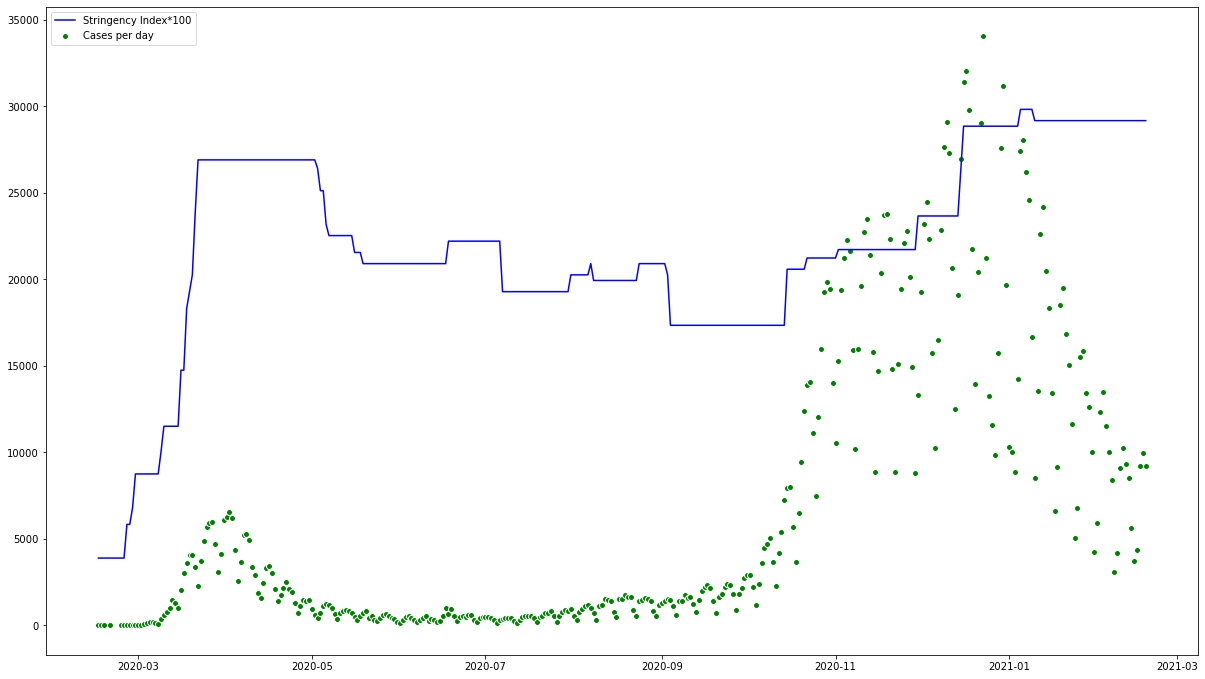

In [48]:
''''''

fig = plt.figure(figsize=(16, 9))
axes = fig.add_axes([0, 0, 1, 1])

axes.scatter(DE_dataset_by_date['date'], DE_dataset_by_date['confirmed_addition'], color="green", label="Cases per day", edgecolors="w")
axes.plot(DE_dataset_by_date['date'], DE_dataset_by_date['stringency_index']*350, color="blue", label="Stringency Index*100")

axes.legend(loc="upper left")

plt.show()